# Generador de laberintos (Implementación del docente)

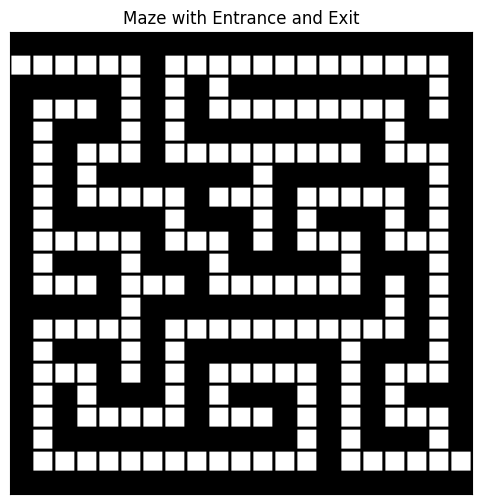

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import random
from matplotlib.colors import ListedColormap

def create_maze(dim):
    # Create a grid filled with walls (1)
    # Set the seed to ensure reproducibility
    np.random.seed(2)
    maze = np.ones((dim * 2 + 1, dim * 2 + 1), dtype=int)

    # Define the starting point
    x, y = (0, 0)
    maze[2 * x + 1, 2 * y + 1] = 0  # Mark start as open path

    # Initialize the stack with the starting point for DFS
    stack = [(x, y)]
    
    while stack:
        x, y = stack[-1]

        # Define possible directions (right, down, left, up)
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        random.shuffle(directions)  # Randomize order for more organic mazes

        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            # Check if next cell is within bounds and is a wall
            if 0 <= nx < dim and 0 <= ny < dim and maze[2 * nx + 1, 2 * ny + 1] == 1:
                # Break wall to create path
                maze[2 * nx + 1, 2 * ny + 1] = 0
                maze[2 * x + 1 + dx, 2 * y + 1 + dy] = 0
                stack.append((nx, ny))  # Move to the next cell
                break
        else:
            stack.pop()  # Backtrack if no unvisited neighbors

    # Create entrance and exit points
    maze[1, 0] = 0  # Entrance
    maze[-2, -1] = 0  # Exit

    return maze

def display_maze(maze):
    cmap = ListedColormap(['white', 'black', 'green', 'black'])
    plt.figure(figsize=(6, 6))
    plt.pcolor(maze[::-1], cmap=cmap, edgecolors='k', linewidths=2)
    plt.gca().set_aspect('equal')
    plt.xticks([])
    plt.yticks([])
    plt.title('Maze with Entrance and Exit')
    plt.show()

# Define the dimension of the maze (adjustable)
dim = 10  # This can be any positive integer
maze = create_maze(dim)
display_maze(maze)

# Implementación del solucionador de laberintos con algoritmos geneticos

**ISIS-3302:** Modelado, Simulación y Optimización

Departamento de Ingeniería de Sistemas y Computación

Universidad de los Andes

### **Integrantes - Grupo 15**

Daniel Felipe Diaz Moreno y Sara Sofía Cárdenas Rodríguez

In [11]:
"""
    Clase auxilar que permite realizar el mapa de calor asociado a un individuo
    
    Parametros:
    maze: Laberinto
    start: Punto de inicio
    solution: Solución encontrada
    generacion: Número de generación
    
    Retorna:
    None
"""

class SolutionDrawer:
    def draw(self, maze, start, solution, generacion):
        counterMatrix = np.zeros(maze.shape, dtype=int)
        x, y = start
        counterMatrix[x][y] += 1
        directions = [(0, 1), (0, -1), (-1, 0), (1, 0)]  
        for move in solution:
            dx, dy = directions[move]
            nx, ny = x + dx, y + dy
            if 0 <= nx < len(maze) and 0 <= ny < len(maze[0]) and maze[nx][ny] == 0:
                x, y = nx, ny
                counterMatrix[x][y] += 1
        plt.figure(figsize=(8, 8))
        plt.title(f"Frecuencia de Movimientos en el Laberinto (Generación {generacion})")
        plt.imshow(counterMatrix, cmap='hot',interpolation='nearest')
        plt.colorbar(label="Número de Visitas")
        plt.xlabel("Columnas")
        plt.ylabel("Filas")
        plt.grid(False)
        plt.show()
        

In [12]:
import random


"""
    Clase que permite resolver el laberinto utilizando algoritmos genéticos usando las funciones de la lista de entregables
"""
class GeneticMazeSolver:
    """
        Genera una población inicial de individuos aleatoria
        
        Parametros:
        size: Tamaño de la población
        genome_length: Longitud del genoma
        
        Retorna:
        Población inicial generada
    """
    def generate_population(self, size, genome_length):
        return [[random.randint(0, 3) for _ in range(genome_length)] for _ in range(size)]
    
    
    """
        Calcula la recompensa asociada a un individuo, penalizando por visitar celdas ya visitadas y por chocar con paredes
        
        Parametros:
        individual: Individuo a evaluar
        maze: Laberinto
        start: Punto de inicio
        end: Punto final
        
        Retorna:
        Recompensa asociada al individuo
    """
    def reward(self, individual, maze, start, end):
        x, y = start
        visited_cells = set()
        directions = [(0, 1), (0, -1), (-1, 0), (1, 0)]   
        total_reward = 500000
        for move in individual:
            dx, dy = directions[move]
            x, y = x + dx, y + dy
            if not (0 <= x < len(maze) and 0 <= y < len(maze[0])) or maze[x][y] == 1:
                x, y = x - dx, y - dy  
                total_reward -= 1000
                continue
            if (x, y) not in visited_cells:
                visited_cells.add((x, y))
                total_reward += 100000
            if (x, y) == end:
                total_reward += 5000000000000
                break
        total_reward -= ((x - end[0])**2 + (y - end[1])**2)**0.5
        return total_reward
    
    """
        Cruza dos individuos para generar dos hijos nuevos usando un punto de corte aleatorio
        
        Parametros:
        parent1: Padre 1
        parent2: Padre 2
        
        Retorna:
        Dos hijos generados
    """
    def crossover(self, parent1, parent2):
        pivot = random.randint(0, len(parent1) - 1)
        child1 = parent1[:pivot] + parent2[pivot:]
        child2 = parent2[:pivot] + parent1[pivot:]
        return child1, child2
    
    """
        Muta un individuo con una probabilidad dada
        
        Parametros:
        individual: Individuo a mutar
        mutation_rate: Probabilidad de mutación
    """
    def mutate(self, individual, mutation_rate):
        for i in range(len(individual)):
            if random.random() < mutation_rate:
                individual[i] = random.randint(0, 3)  
                
    """
        Selecciona dos individuos de la población usando selección por ruleta
        
        Parametros:
        population: Población actual
        fitnesses: Lista de recompensas asociadas a la población
        
        Retorna:
        Dos individuos seleccionados
    """
    def select(self, population, fitnesses):
        totalFitness = sum(fitnesses)
        padres = []
        for _ in range(2):
            ruleta = random.uniform(0, totalFitness)
            acumulado = 0
            for i in range(len(population)):
                acumulado += fitnesses[i]
                if acumulado > ruleta:
                    padres.append(population[i])
                    break
        return padres


    """
        Evoluciona la población durante un número de generaciones dado
        
        Parametros:
        population: Población inicial
        maze: Laberinto
        start: Punto de inicio
        end: Punto final
        
        Retorna:
        Mejor individuo encontrado y su recompensa asociada
    """
    def evolve(self, population, maze, start, end):
        drawer = SolutionDrawer()
        generaciones = 100
        fitnesses = [self.reward(individual, maze, start, end) for individual in population]
        for i in range(generaciones):
            nuevaPoblacion = []
            for _ in range(len(population) - int(0.2 * len(population))):
                padre1, padre2 = self.select(population, fitnesses)
                if random.random() < 0.8:
                    hijo1, hijo2 = self.crossover(padre1, padre2)
                else:
                    hijo1, hijo2 = padre1, padre2
                nuevaPoblacion.extend([hijo1, hijo2])
                nuevaPoblacion.sort(key=lambda x: self.reward(x, maze, start, end), reverse=True)
                
                nuevaPoblacion = nuevaPoblacion[:len(population)]
                
            for individuo in nuevaPoblacion:
                self.mutate(individuo, 0.08)


            population.sort(key=lambda individuo: self.reward(individuo, maze, start, end), reverse=True)
            nuevaPoblacion.sort(key=lambda individuo: self.reward(individuo, maze, start, end), reverse=True)
           
            populationSize = len(population)
            population =  population[:int(0.2 * len(population))] + nuevaPoblacion[:populationSize - int(0.2 * len(population))]
            fitnesses = [self.reward(individual, maze, start, end) for individual in population]
            mejorIndividuo = population[0]
            mejorFitness = self.reward(mejorIndividuo, maze, start, end)
            drawer.draw(maze, start, mejorIndividuo, i+1)

        return mejorIndividuo, mejorFitness

# Pruebas

## generate_population(size, genome_length)

In [13]:
"""
    (TEST) Prueba que la longitud del genoma sea correcta para cada individuo de la población
"""
def probarLongitudGenoma():
    longitudesGenoma = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
    tamañoPoblacion = 100
    solver = GeneticMazeSolver()
    for i,longitudGenoma in enumerate(longitudesGenoma):
        poblacion = solver.generate_population(tamañoPoblacion, longitudGenoma)
        assert len(poblacion) == tamañoPoblacion, f"Error en la prueba {i+1} el tamaño de la población es incorrecto"
        for individuo in poblacion:
            assert len(individuo) == longitudGenoma, f"Error en la prueba {i+1} la longitud del genoma es incorrecta en el individuo {individuo}"
        
"""
    (TEST) Prueba que la longitud de la población sea correcta
"""    
def probarLongitudPoblacion():
    longitudGenoma = 100
    tamañosPoblacion = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
    solver = GeneticMazeSolver()
    for i,tamañoPoblacion in enumerate(tamañosPoblacion):
        poblacion = solver.generate_population(tamañoPoblacion, longitudGenoma)
        assert len(poblacion) == tamañoPoblacion, f"Error en la prueba {i+1} el tamaño de la población es incorrecto"
        for individuo in poblacion:
            assert len(individuo) == longitudGenoma, f"Error en la prueba {i+1} la longitud del genoma es incorrecta en el individuo {individuo}"
       
"""
    (TEST) Prueba que las direcciones de los individuos sean válidas
"""     
def probarDireccionesPoblacion():
    longitudesGenoma = [5,20,40]
    tamañosPoblacion = [5, 20, 50]
    solver = GeneticMazeSolver()
    for i,longitudGenoma in enumerate(longitudesGenoma):
        for j,tamañoPoblacion in enumerate(tamañosPoblacion):
            poblacion = solver.generate_population(tamañoPoblacion, longitudGenoma)
            for individuo in poblacion:
                for direccion in individuo:
                    assert direccion in [0,1,2,3], f"Error en la prueba {i}, {j} la dirección {direccion} no es válida en el individuo {individuo}"
                    
probarLongitudGenoma()
probarLongitudPoblacion()
probarDireccionesPoblacion()

## reward(individual, maze, start, end)

In [14]:
"""
    (TEST) Prueba que la recompensa del individuo óptimo sea mayor que la del ineficaz en un laberinto sin obstáculos donde el optimo llega al final
"""
def pruebaRecompensaSinObstaculos():
    laberinto = np.array([[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]])
    start = (0, 0)
    end = (4, 4)
    individuoOptimo = [0, 0, 0, 0, 3, 3, 3, 3]
    individuoIneficaz = [0, 3, 1, 2, 0, 3, 1, 2]
    solver = GeneticMazeSolver()
    recompensaOptimo = solver.reward(individuoOptimo, laberinto, start, end)
    recompensaIneficaz = solver.reward(individuoIneficaz, laberinto, start, end)    
    assert recompensaOptimo > recompensaIneficaz, f"Error en la prueba de recompensa, la recompensa del individuo óptimo es menor que la del ineficaz"
   
"""
    (TEST) Prueba que la recompensa del individuo óptimo sea mayor que la del ineficaz en un laberinto con obstáculos donde el optimo no llega al final
""" 
def pruebaRecompensaConObstaculos():
    laberinto = np.array([[0, 0, 0, 0, 0], [1, 1, 1, 1, 0], [1, 1, 1, 1, 0], [1, 1, 1, 1, 0], [1, 1, 1, 1, 0]])
    start = (0, 0)
    end = (4, 4)
    individuoOptimo = [0, 0, 0, 0, 3, 3, 2, 2]
    individuoIneficaz = [0, 3, 0, 3, 0, 3, 0, 3]
    solver = GeneticMazeSolver()
    recompensaOptimo = solver.reward(individuoOptimo, laberinto, start, end)
    recompensaIneficaz = solver.reward(individuoIneficaz, laberinto, start, end)
    assert recompensaOptimo > recompensaIneficaz, f"Error en la prueba de recompensa, la recompensa del individuo óptimo es menor que la del ineficaz"
    
pruebaRecompensaSinObstaculos()
pruebaRecompensaConObstaculos()

## select(population, fitnesses)

In [15]:
"""
    (Test) En esta prueba se tienen 9 invidiuos no optimos y un optimo, se espera que con una seleccion equitativa, cada individuo sea seleccionado al menos una vez.
    Debido a que el metodo de la ruleta beneficia a los individuos con mayor recompensa, se espera que el individuo optimo sea seleccionado al menos 3 veces.
    
    Nota: Debido a factores probabilisticos, este test puede fallar en raras ocasiones.
"""

def revisarProbabilidadSeleccion():
    laberinto = np.array([[0, 0, 0, 0, 0], [1, 1, 1, 1, 0], [1, 1, 1, 1, 0], [1, 1, 1, 1, 0], [1, 1, 1, 1, 0]])
    solver = GeneticMazeSolver()
    poblacion = [[0, 3, 0, 3, 0, 3, 0, 3] for _ in range(10)]
    poblacion[-1] = [0, 0, 0, 0, 3, 3, 3, 3]
    fitnesses = [solver.reward(individual, laberinto, (0, 0), (4, 4)) for individual in poblacion]
    
    conteoAparicionMejorIndividuo = 0
    for _ in range(5):
        padre1, padre2 = solver.select(poblacion, fitnesses)
        if padre1 == poblacion[-1]:
            conteoAparicionMejorIndividuo += 1
        if padre2 == poblacion[-1]:
            conteoAparicionMejorIndividuo += 1
    assert conteoAparicionMejorIndividuo > 3, "Error en la prueba de selección, el mejor individuo no fue seleccionado con la frecuencia esperada"    
    
revisarProbabilidadSeleccion()

## crossover(parent1, parent2)

In [16]:
"""
    (TEST) Prueba que el punto de corte sea válido en los hijos generados (la primera parte del genoma de un hijo debe ser de un padre y la segunda de otro)
"""
def probarCorte():
    padre1 = [0,1,0,1,0,1,0,1]
    padre2 = [2,3,2,3,2,3,2,3]
    solver = GeneticMazeSolver()
    hijo1, hijo2 = solver.crossover(padre1, padre2)
    i = 0
    j = 0
    while i<len(hijo1) and (hijo1[i] == 0 or hijo1[i] == 1):
        i += 1
    while i<len(hijo1) and (hijo1[i] == 2 or hijo1[i] == 3):
        i += 1
    while j<len(hijo2) and (hijo2[j] == 2 or hijo2[j] == 3):
        j += 1
    while j<len(hijo2) and (hijo2[j] == 0 or hijo2[j] == 1):
        j += 1
    assert len(hijo1) == len(padre1), "Error en la prueba de cruce, el hijo 1 no tiene la misma longitud que el padre 1"
    assert len(hijo2) == len(padre1), "Error en la prueba de cruce, el hijo 2 no tiene la misma longitud que el padre 1"
    assert len(hijo1) == len(padre1), "Error en la prueba de cruce, el hijo 1 no tiene la misma longitud que el padre 2"
    assert len(hijo2) == len(padre1), "Error en la prueba de cruce, el hijo 2 no tiene la misma longitud que el padre 2"
    assert i == len(hijo1), "Error en la prueba de cruce, el punto de corte no pacere valido en el hijo 1"
    assert j == len(hijo2), "Error en la prueba de cruce, el punto de corte no pacere valido en el hijo 2"
probarCorte()

## mutate(individual, mutation_rate)

In [17]:
"""
    (TEST) Prueba que la mutación sea efectiva (al menos un gen del individuo debe cambiar probabilisticamente)
"""
def pruebaMutacionTasaCompleta():
    individuo = [0, 0, 0, 0, 0, 0, 0, 0]
    solver = GeneticMazeSolver()
    solver.mutate(individuo, 1)
    assert sum(individuo) > 0, "Error en la prueba de mutación, el individuo no fue mutado"
    
def pruebaMutacionTasaNula():
    individuo = [0, 0, 0, 0, 0, 0, 0, 0]
    solver = GeneticMazeSolver()
    solver.mutate(individuo, 0)
    assert sum(individuo) == 0, "Error en la prueba de mutación, el individuo no fue mutado"
    
pruebaMutacionTasaCompleta()
pruebaMutacionTasaNula()

# Reporte


# Descripción de las funciones del `GeneticMazeSolver`


## **`generate_population`**
Esta función es responsable de crear la población inicial, compuesta por individuos aleatorios. Cada individuo se representa como un genoma, que es una lista de movimientos posibles en el laberinto. Este proceso establece las bases del algoritmo genético, asegurando una diversidad inicial esencial para explorar el espacio de soluciones. La diversidad en la población inicial evita que el algoritmo comience con un sesgo hacia una dirección específica, maximizando las posibilidades de descubrir una solución óptima.

---

## **`reward`**
La función de recompensa es un componente crítico que guía la evolución de la población. Evalúa cada individuo en función de su desempeño en el laberinto, asignando una puntuación que premia el progreso hacia el objetivo y penaliza errores como revisitar celdas o chocar contra paredes. También incluye una penalización basada en la distancia al objetivo, lo que motiva a los individuos a acercarse al punto final. Este sistema de evaluación asegura que las generaciones futuras estén formadas por individuos con mejores características, acelerando la convergencia hacia una solución eficiente.

---

## **`crossover`**
El proceso de cruza combina dos individuos seleccionados como padres para generar nuevos individuos (hijos) mediante un punto de corte aleatorio. Este paso es fundamental para la exploración del espacio de búsqueda, ya que mezcla las características de los padres y crea combinaciones genéticas que podrían no existir en la población actual. Al hacerlo, la cruza incrementa las posibilidades de encontrar soluciones que sean más efectivas.

---

## **`mutate`**
La función de mutación altera aleatoriamente genes individuales en el genoma de un individuo con una probabilidad definida. Esta aleatoriedad introduce nuevas características genéticas en la población, preservando la diversidad genética y previniendo que el algoritmo se estanque en óptimos locales. La mutación actúa como un mecanismo de escape, permitiendo explorar áreas del espacio de búsqueda que no serían accesibles solo con cruza y selección.

---

## **`select`**
La función de selección implementa el método de ruleta para elegir dos individuos de la población. Este método asigna una probabilidad proporcional a la recompensa de cada individuo, favoreciendo a los de mejor rendimiento, pero también permitiendo la participación de los demás. Este equilibrio entre explotación y exploración es clave para mantener la diversidad y asegurar que las soluciones prometedoras tengan mayores probabilidades de contribuir a la siguiente generación.

---

## **`evolve`**
La función de evolución combina todos los elementos del algoritmo genético: generación de recompensas, selección, cruza y mutación, para iterar sobre la población a través de múltiples generaciones. Este proceso permite que la población evolucione progresivamente hacia soluciones más óptimas. La evolución se ajusta mediante parámetros como la tasa de mutación, la probabilidad de cruza y el número de generaciones. La función también incluye la visualización opcional del progreso, lo que facilita la evaluación y ajuste del algoritmo. Al final, devuelve el mejor individuo y su puntuación, representando la solución más efectiva encontrada.



## Desafios encontrados
La implementación del algoritmo representó un desafío significativo debido a la cantidad de funciones interdependientes necesarias para su funcionamiento completo. Esto exigió una planificación cuidadosa para garantizar que cada componente trabajara en armonía con los demás mientras se cumplia con la plantilla dada de entregables.

Sin embargo, el mayor desafío surgió en la configuración de los diversos parámetros del modelo, como la tasa de mutación, el número de generaciones y los valores asociados a las recompensas y penalizaciones dentro de la función de evaluación. Fue necesario realizar numerosas pruebas y ajustes para encontrar una combinación de parámetros que permitiera al algoritmo alcanzar soluciones óptimas en un tiempo razonable. Al inicio, el modelo tendía a quedarse atrapado en óptimos locales, lo que requería modificaciones iterativas para mejorar su capacidad de exploración y convergencia hacia mejores resultados.

## Observaciones del desempeño del algoritmo
El algoritmo genético presentado demostró un desempeño satisfactorio al encontrar soluciones óptimas al problema planteado. Sin embargo, es importante destacar que algoritmos determinísticos como DFS o A* suelen ser más eficientes en términos de tiempo de ejecución, ya que resuelven laberintos con complejidad polinómica y ofrecen resultados más precisos y confiables.

A pesar de estas limitaciones, el enfoque basado en algoritmos genéticos tiene la ventaja de ser más flexible y adaptable a nuevas restricciones. Por ejemplo, si se introdujeran reglas adicionales, como requerir que al pasar por una celda específica se deba visitar otra, un algoritmo genético podría abordar estas variaciones con relativa facilidad. En contraste, los algoritmos determinísticos suelen ser menos efectivos frente a problemas con restricciones dinámicas o inusuales.

Como se mencionó en la sección de desafíos, el éxito del algoritmo genético dependió en gran medida de una selección cuidadosa de los parámetros, tales como la tasa de mutación, el número de generaciones y la configuración de la función de recompensa. Solo a través de un ajuste meticuloso de estos valores se logró que el algoritmo no solo fuera eficiente en tiempo, sino que también mejorara progresivamente en la calidad de las soluciones encontradas.

# Demostración final

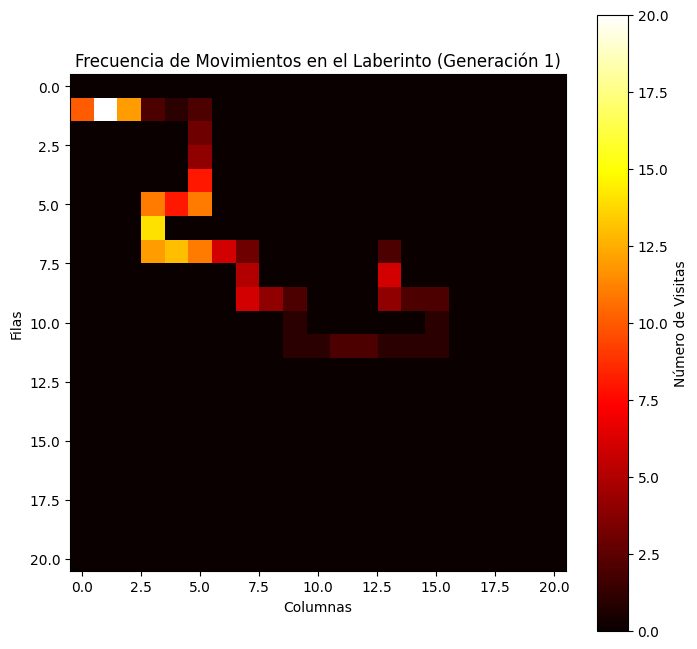

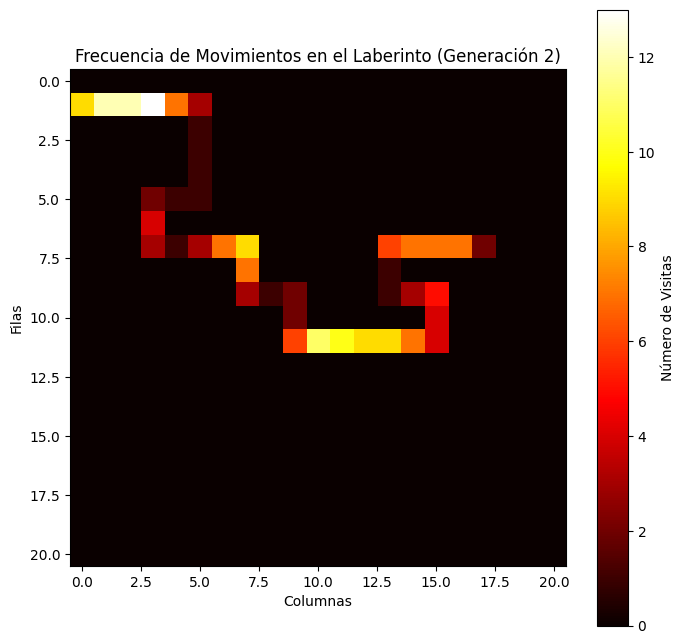

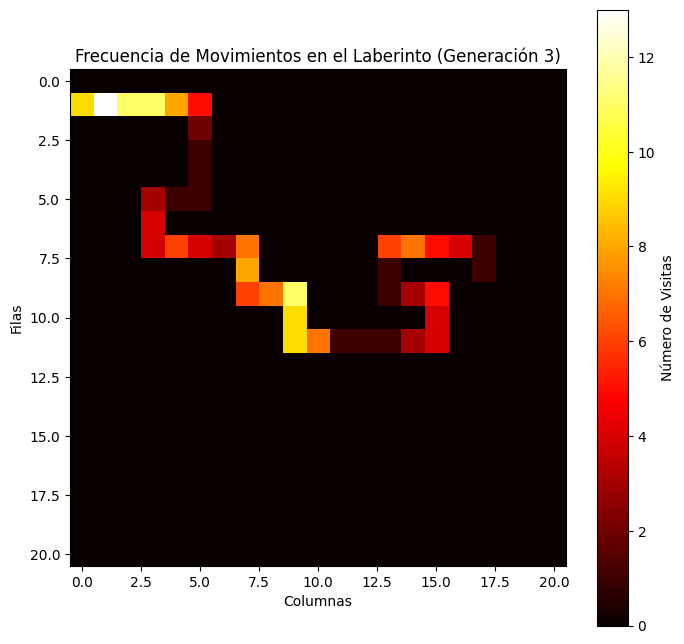

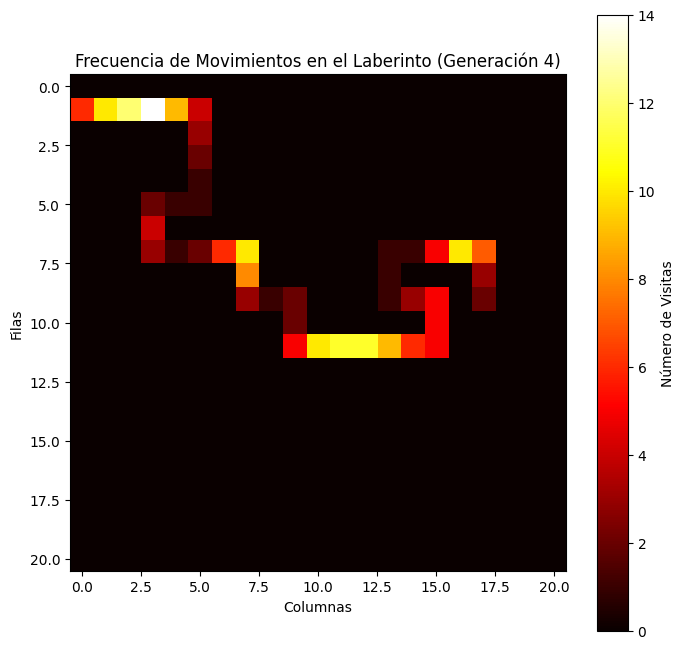

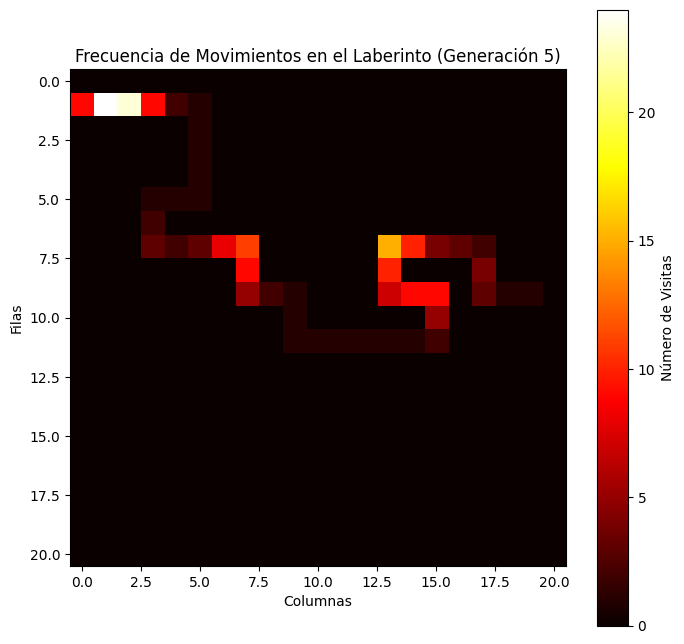

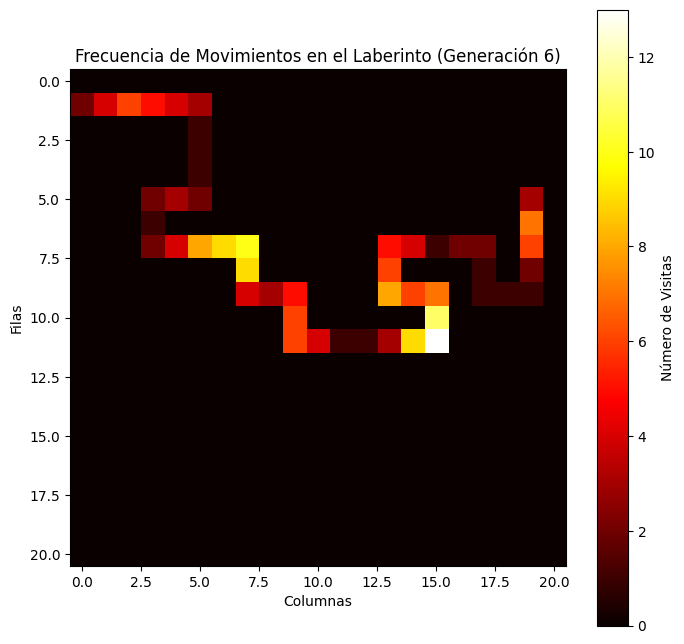

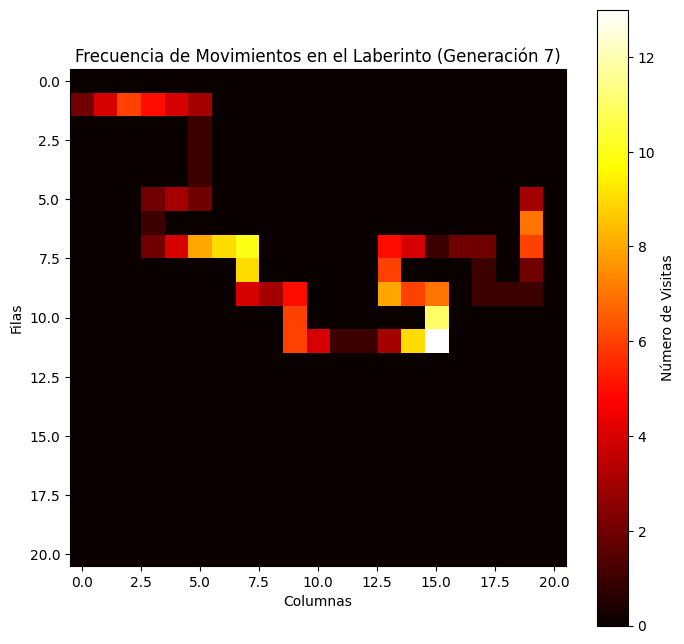

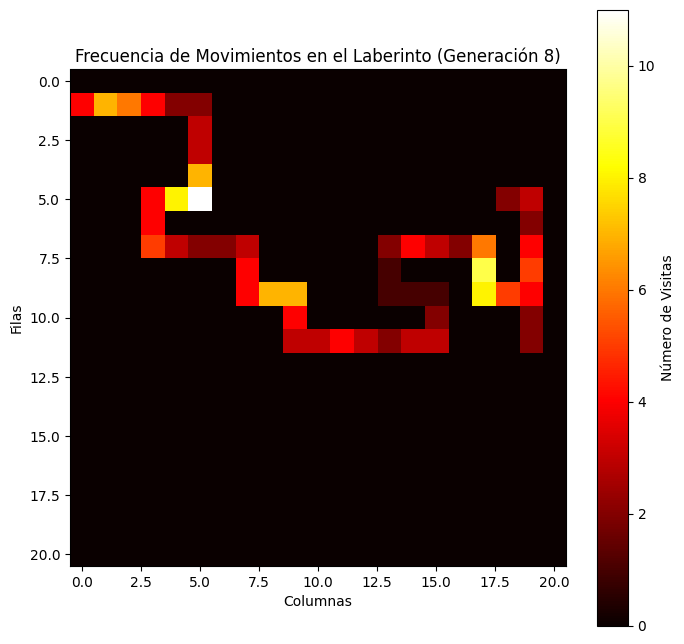

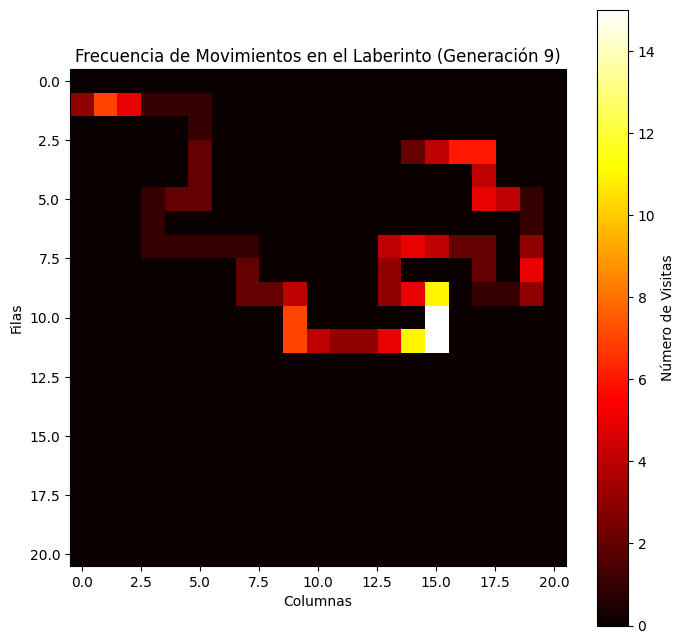

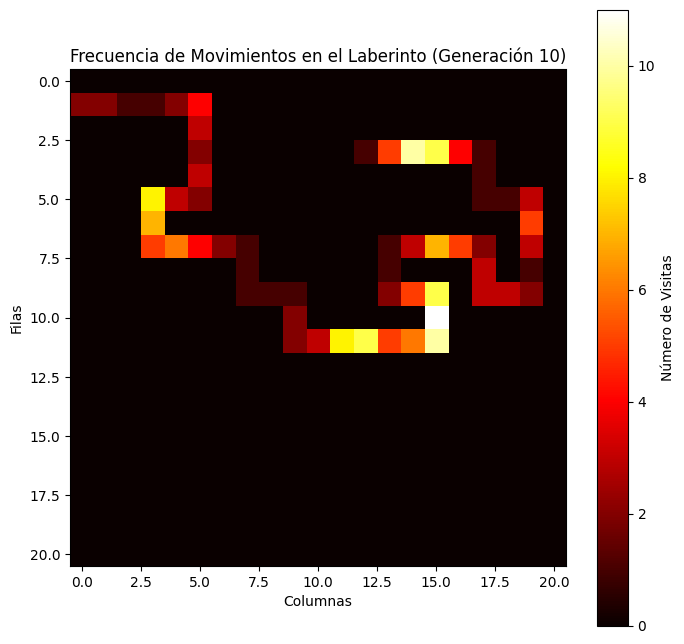

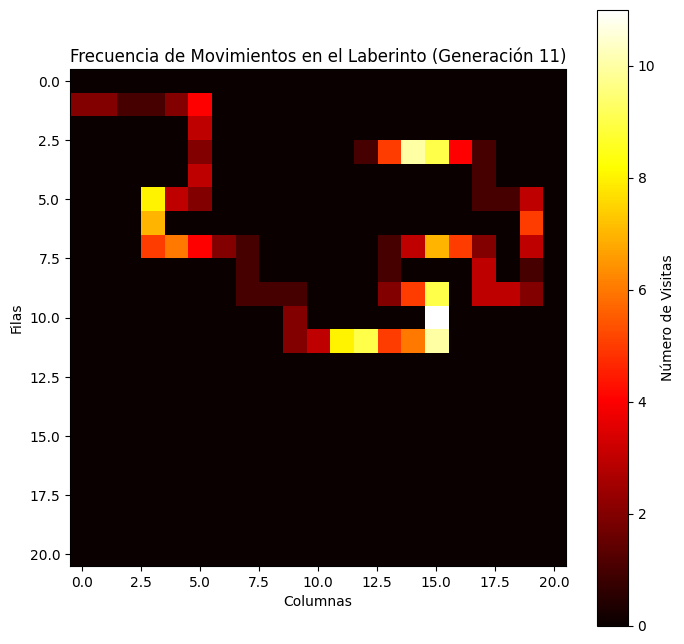

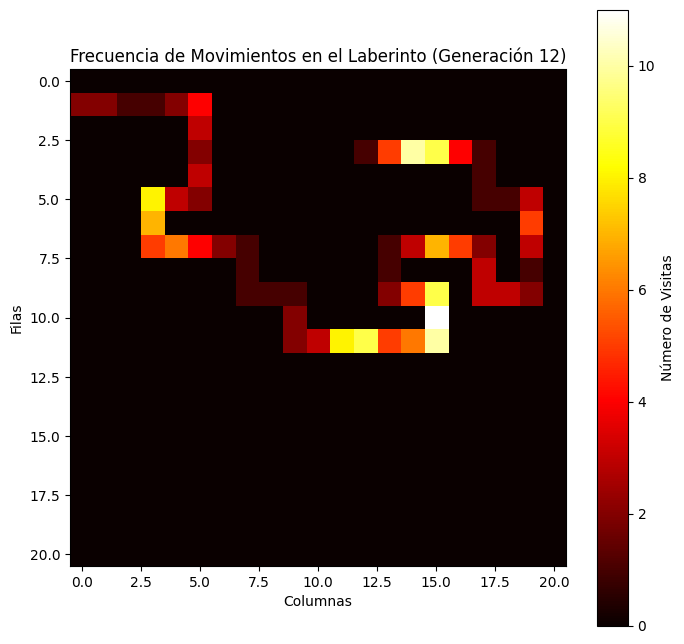

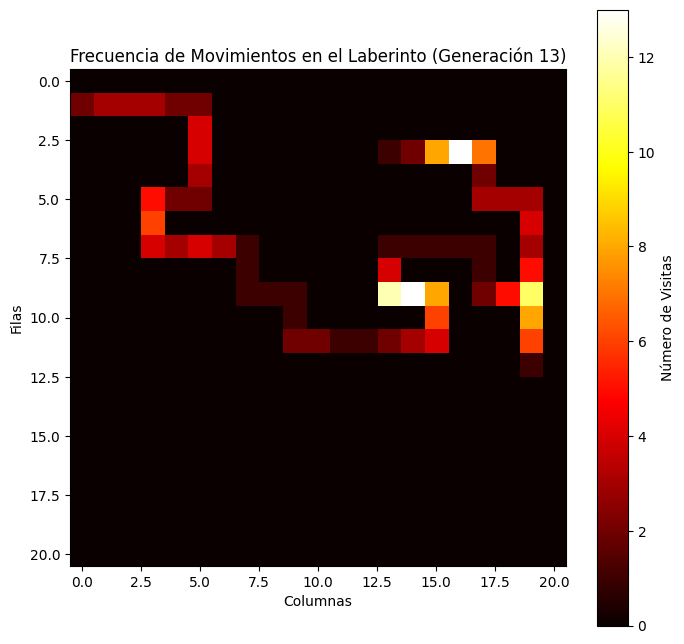

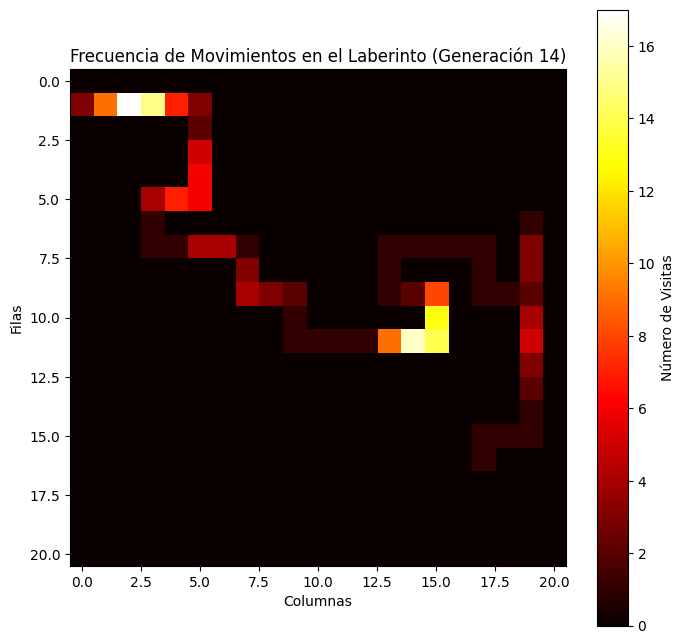

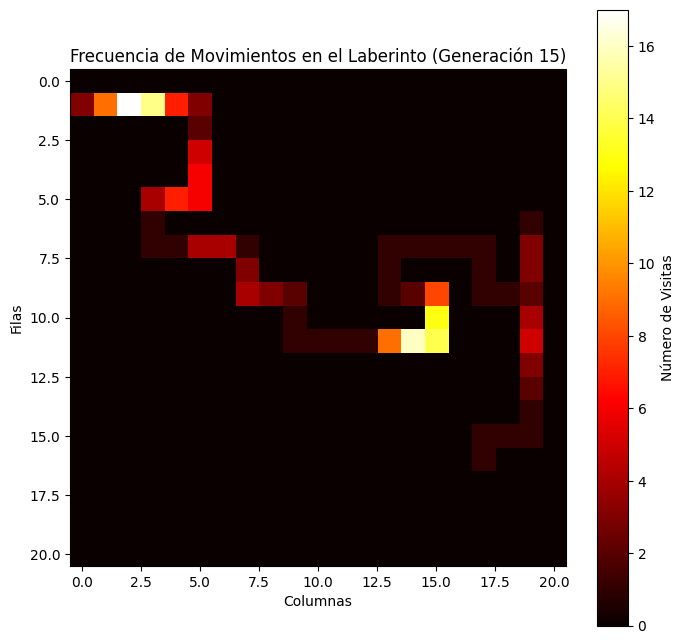

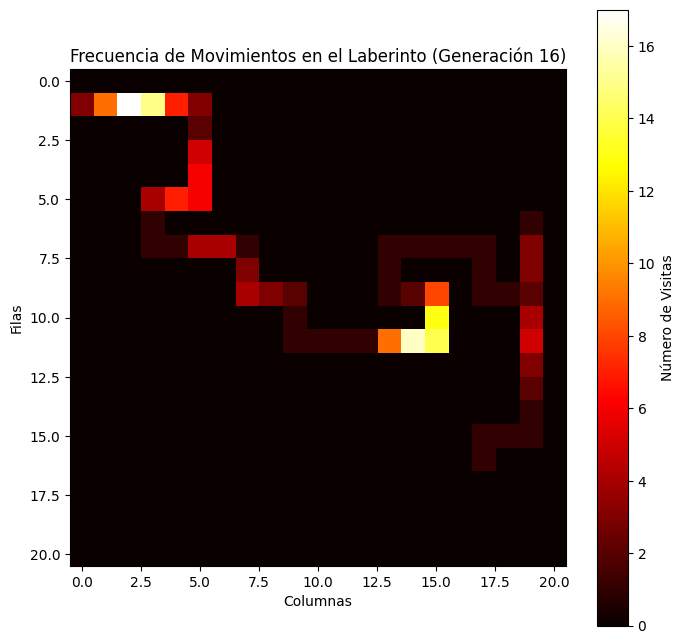

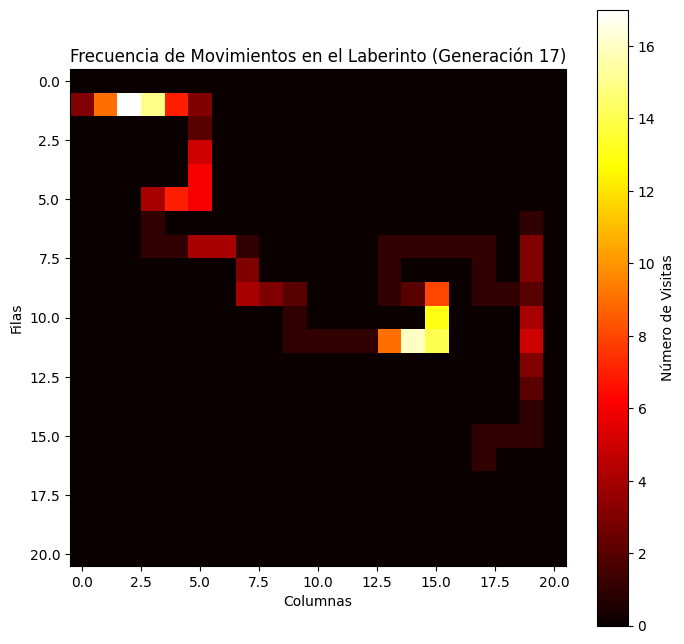

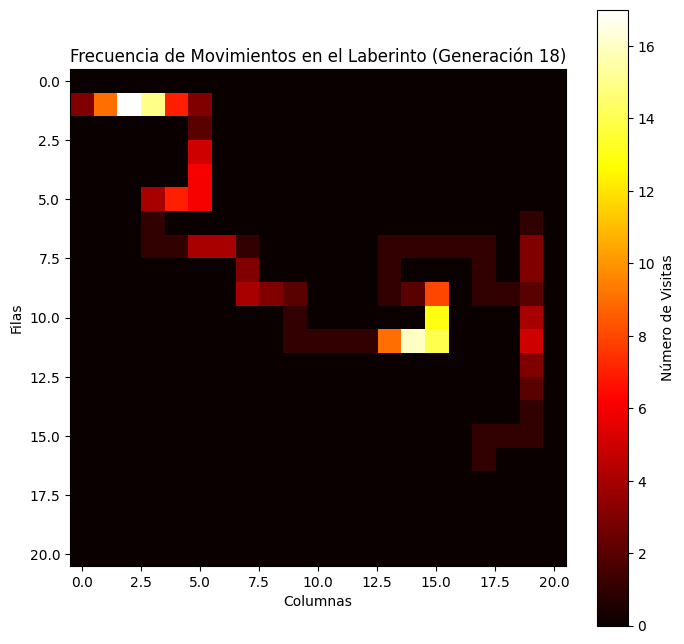

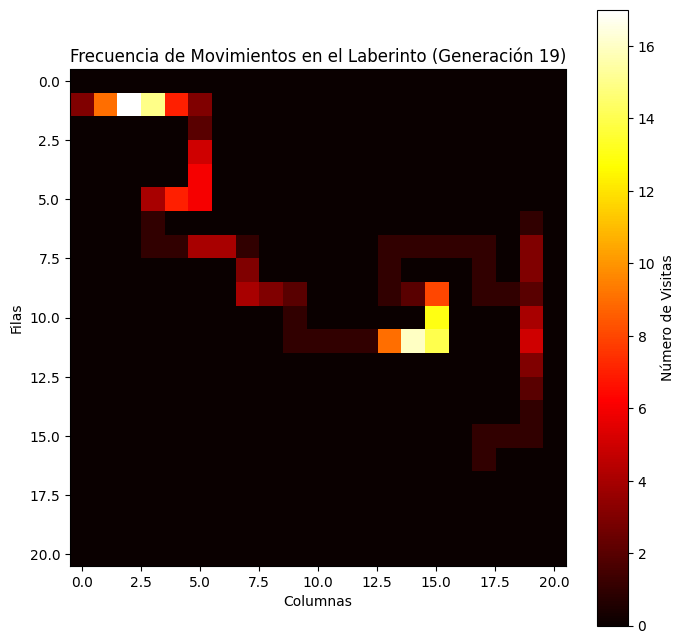

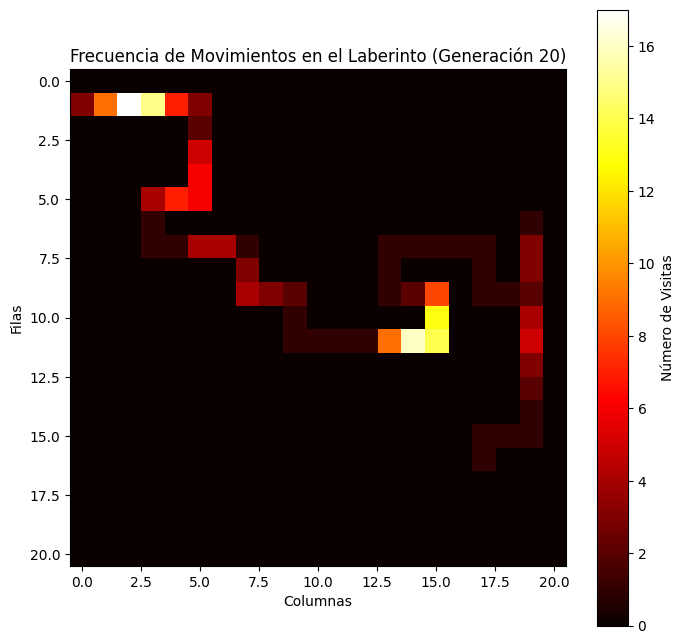

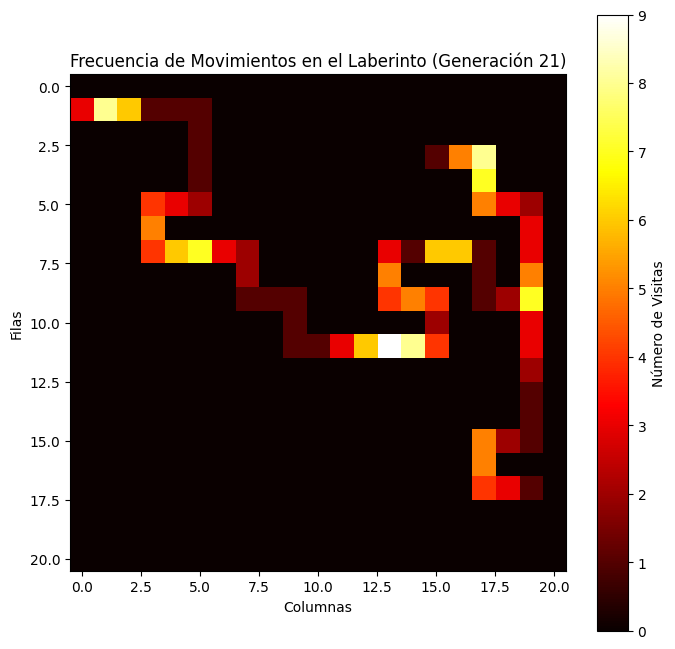

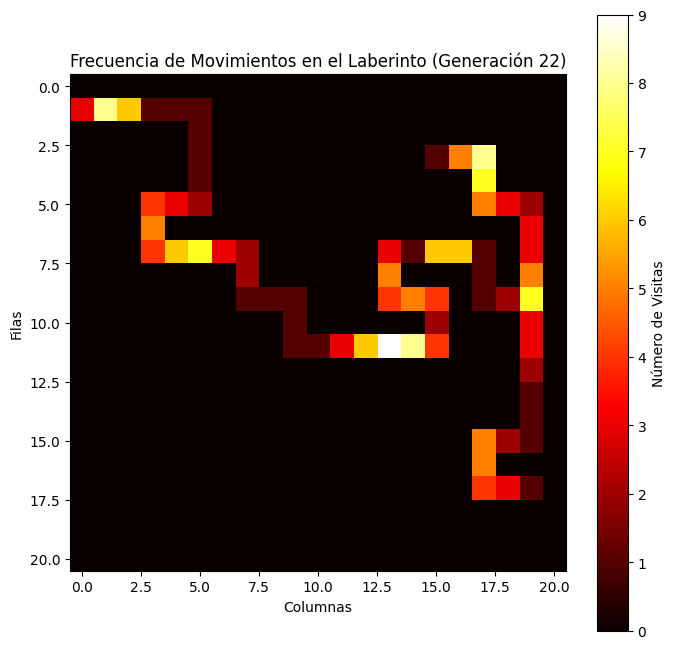

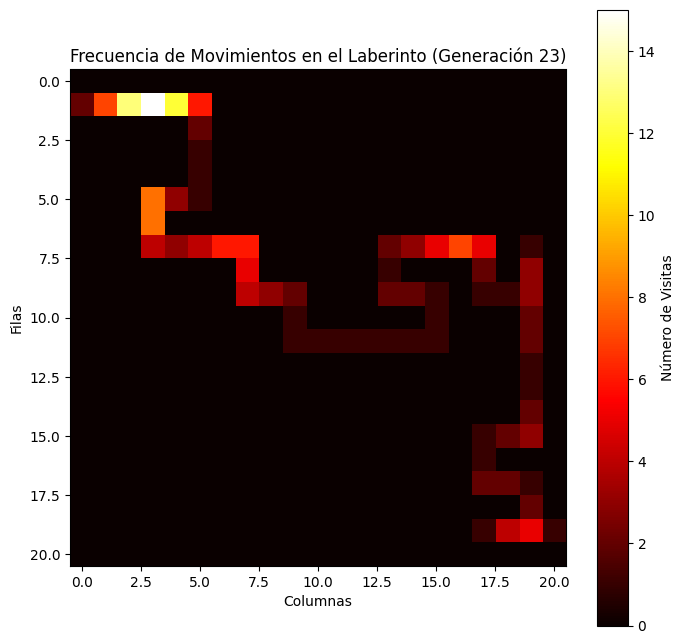

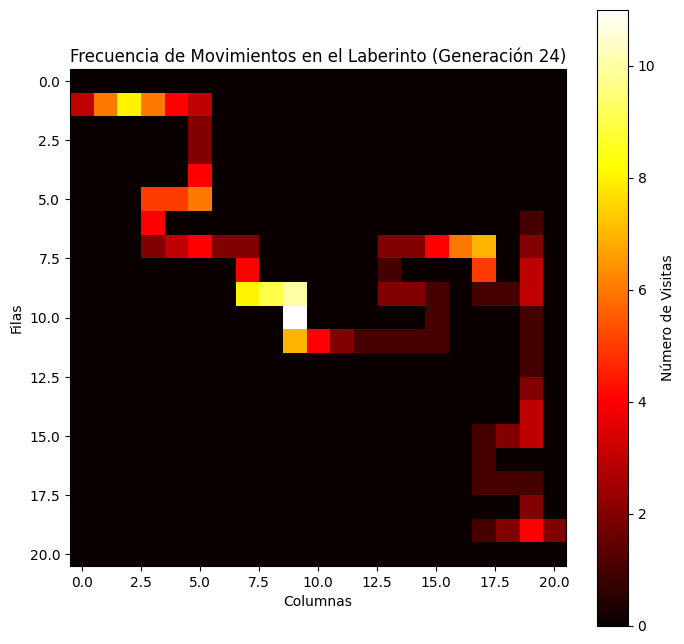

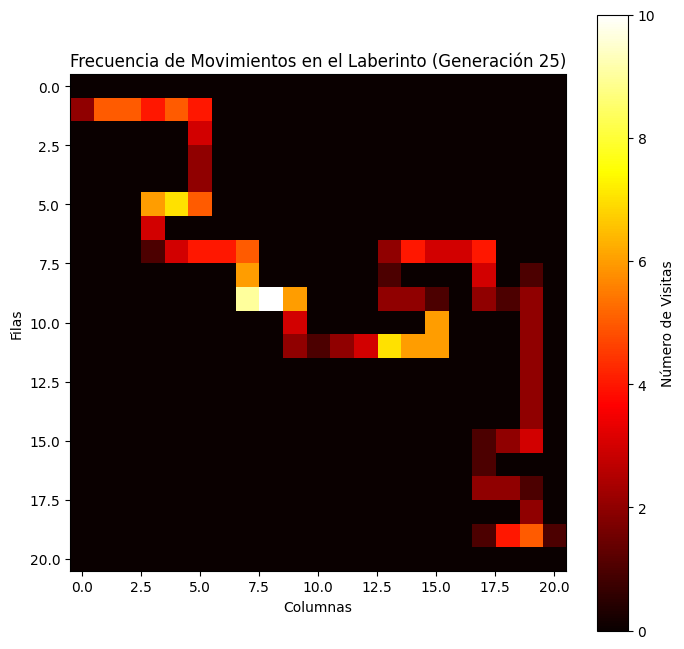

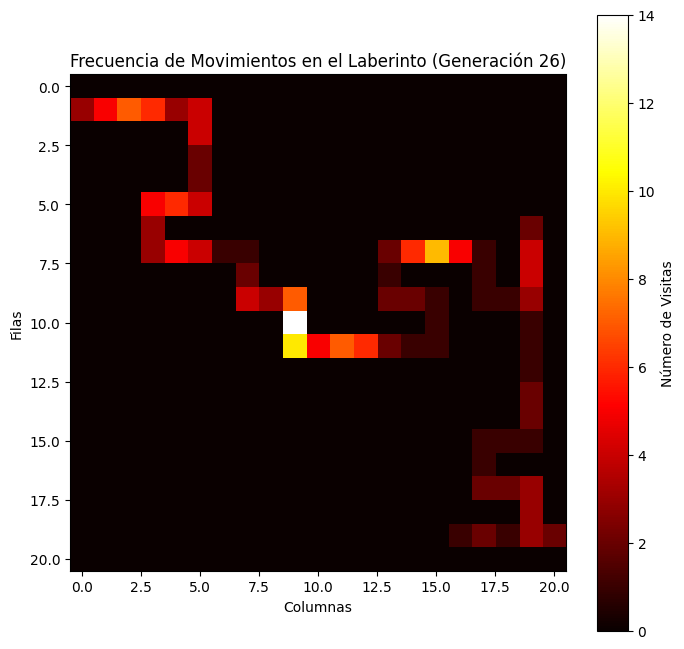

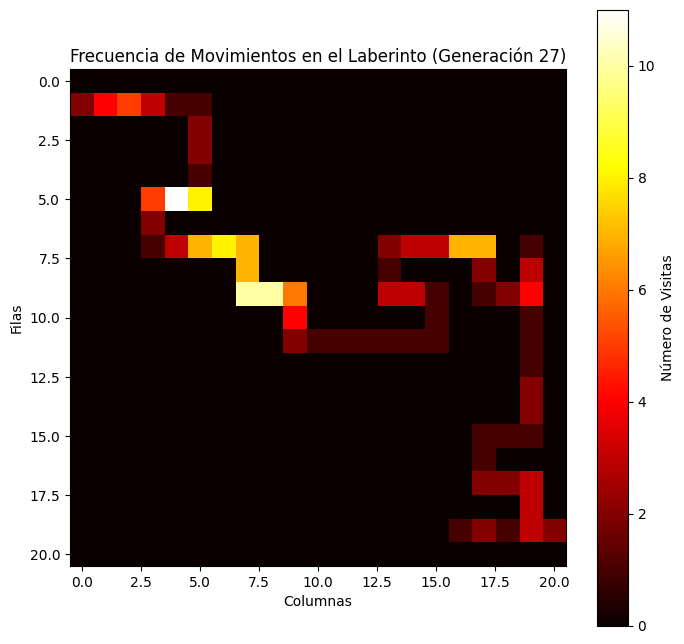

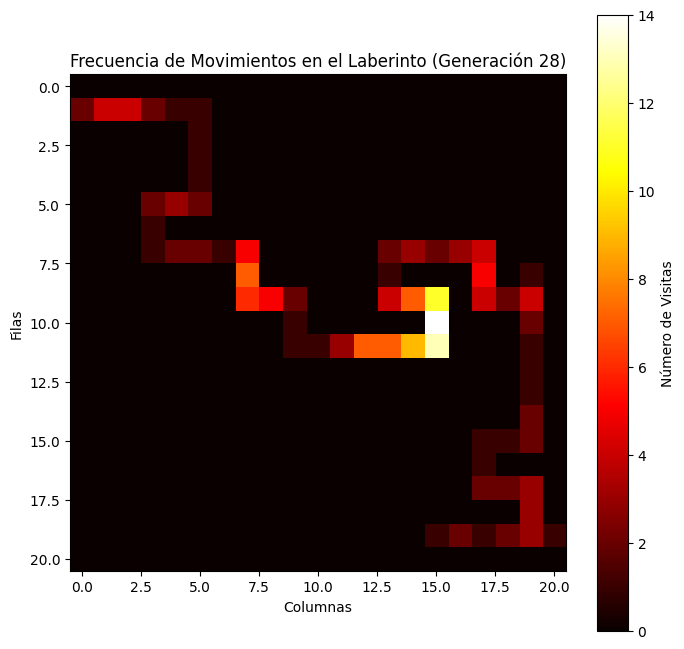

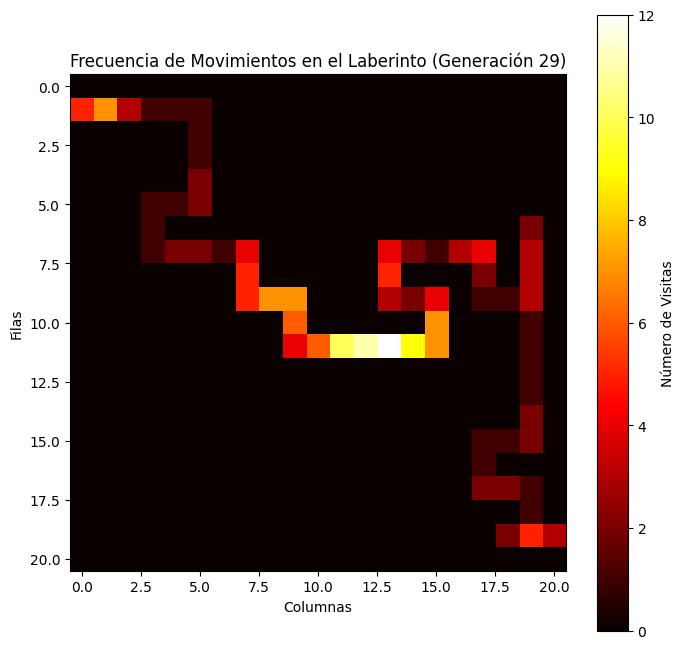

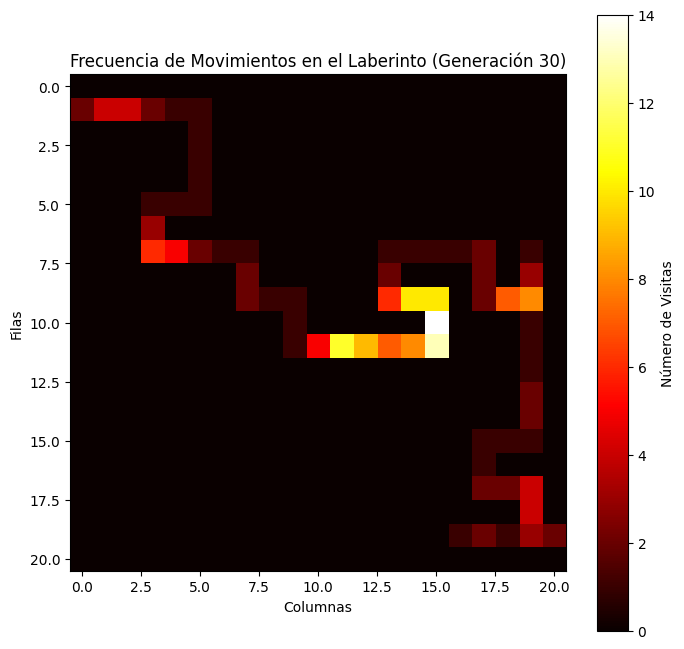

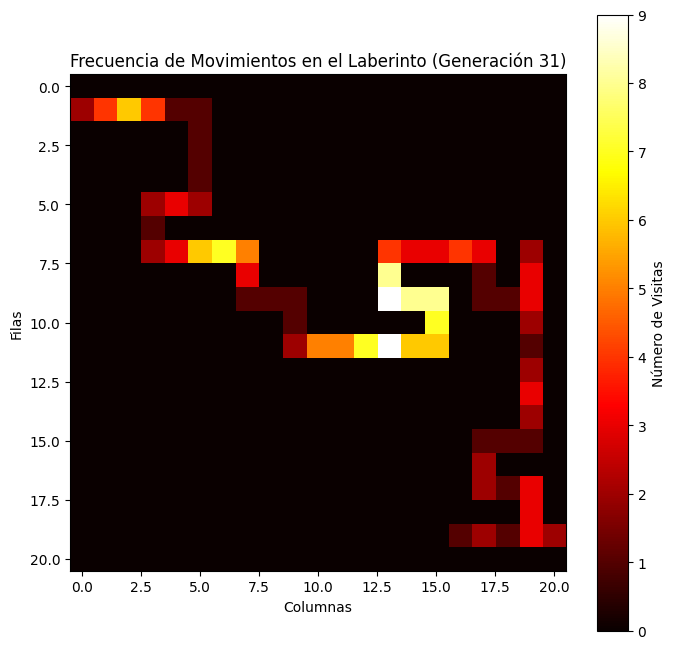

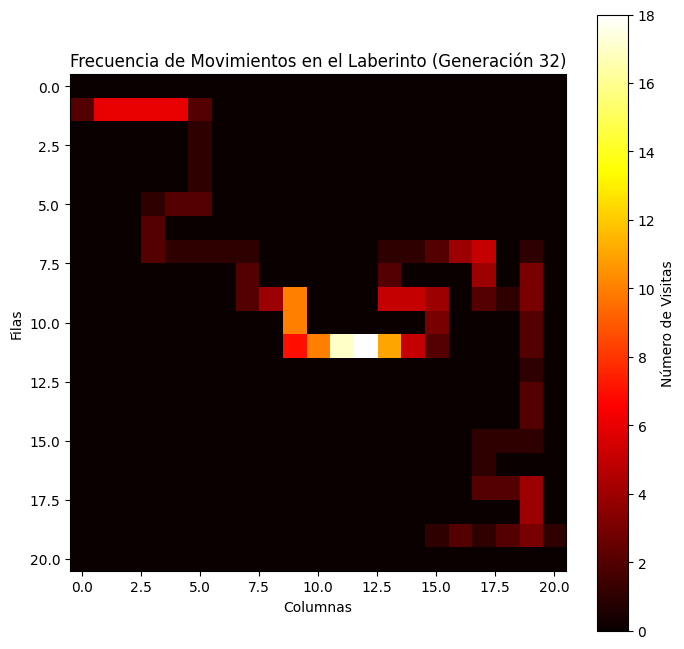

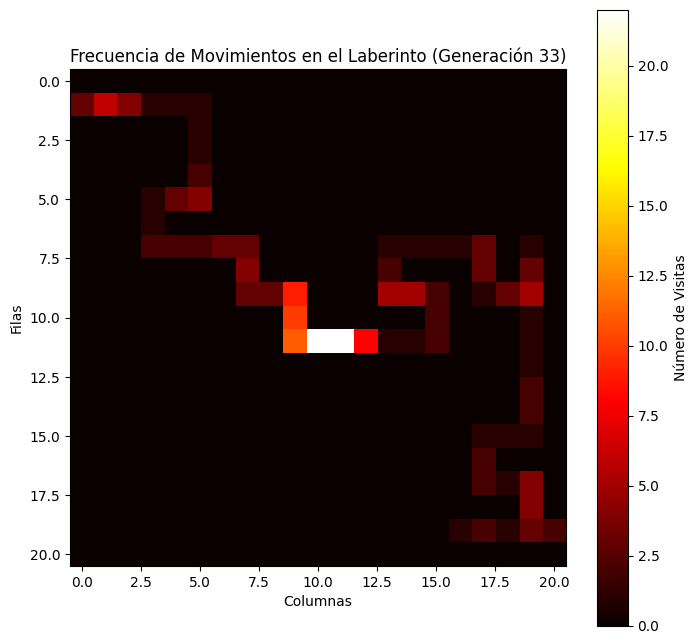

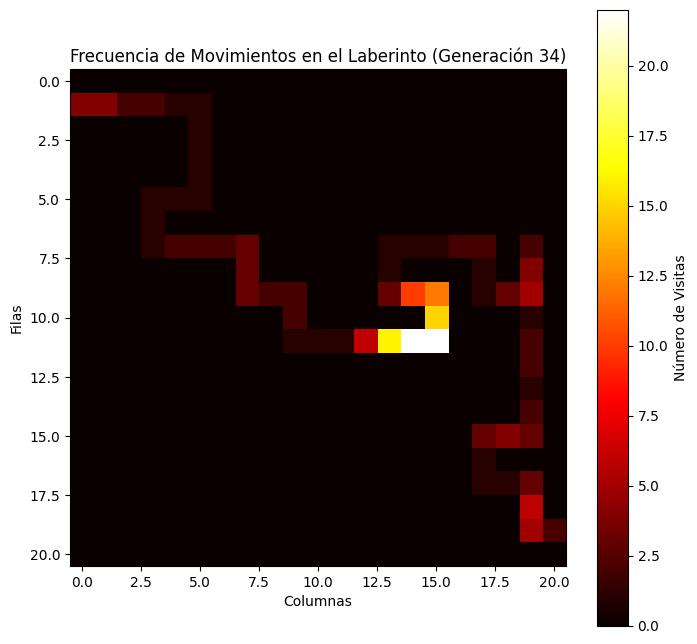

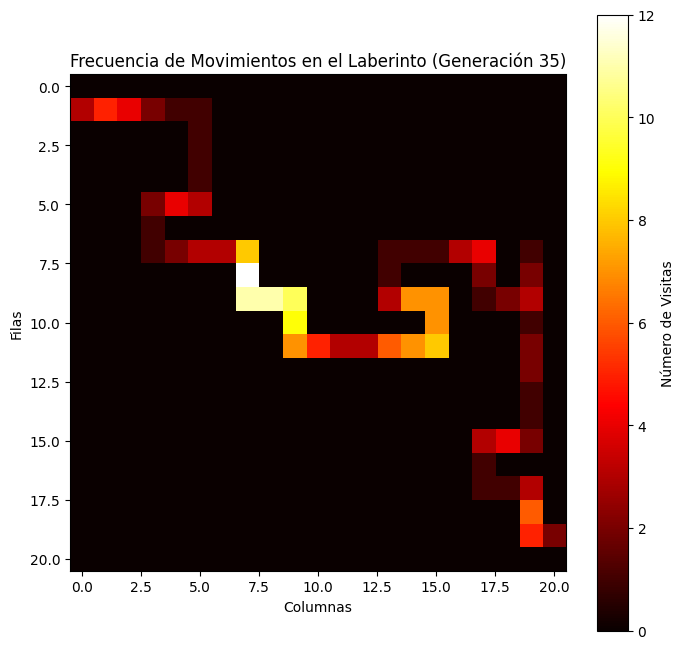

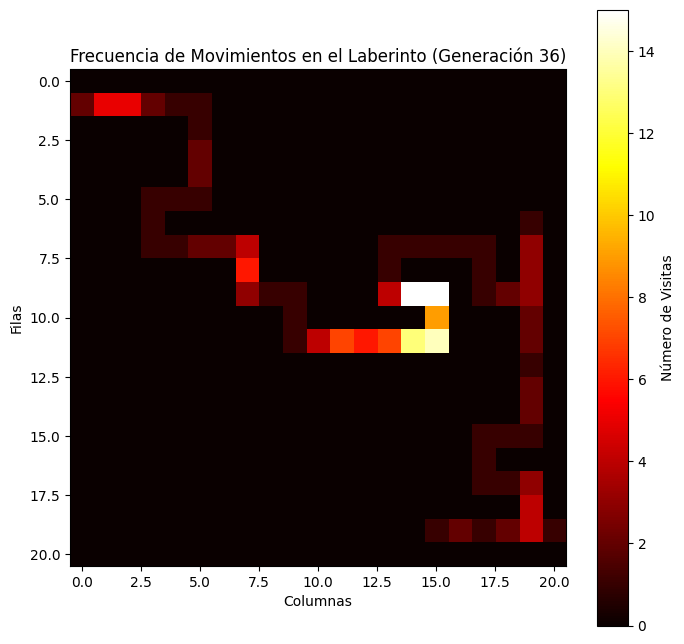

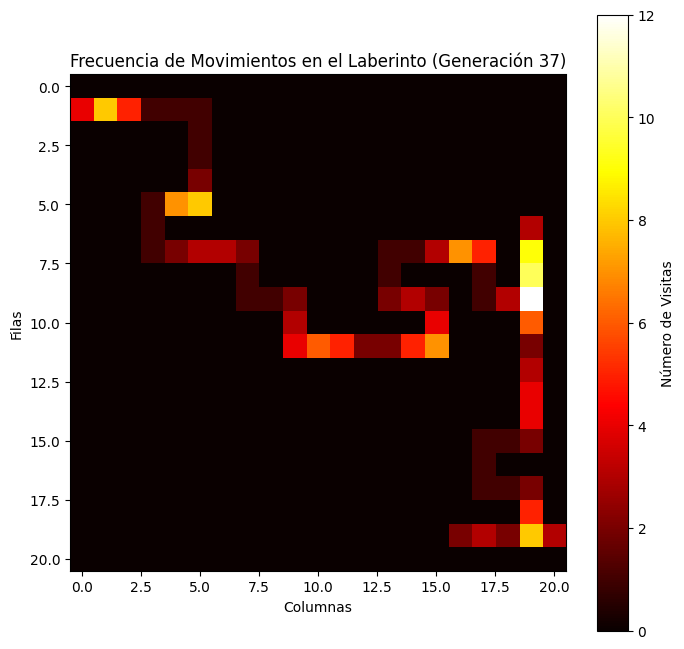

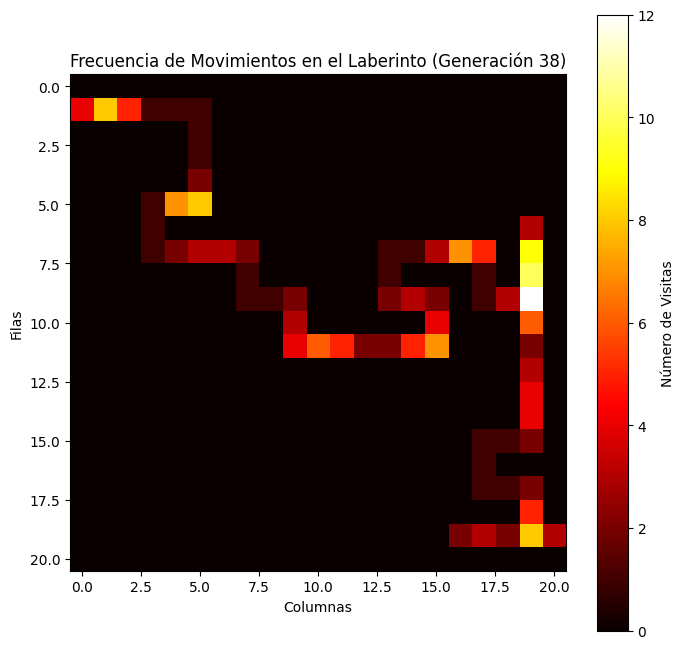

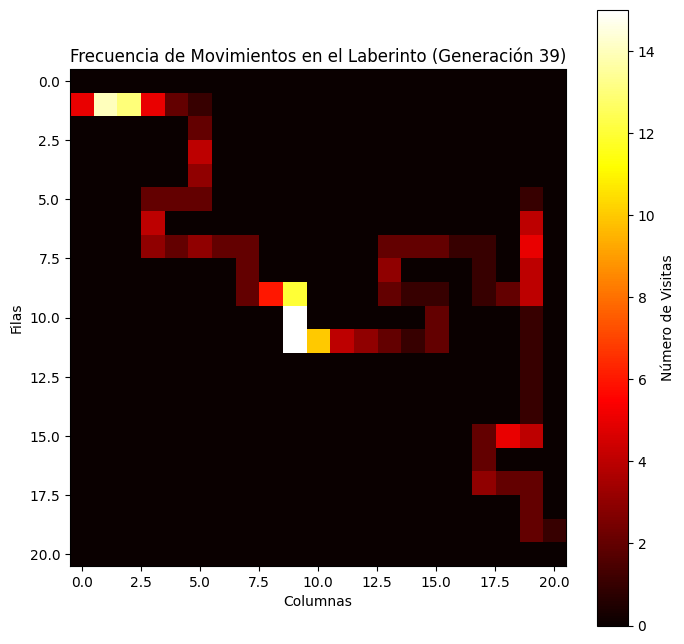

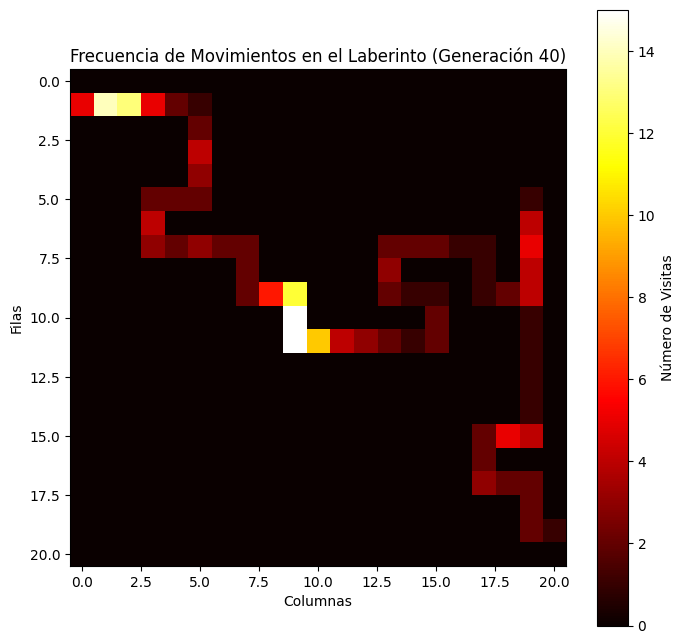

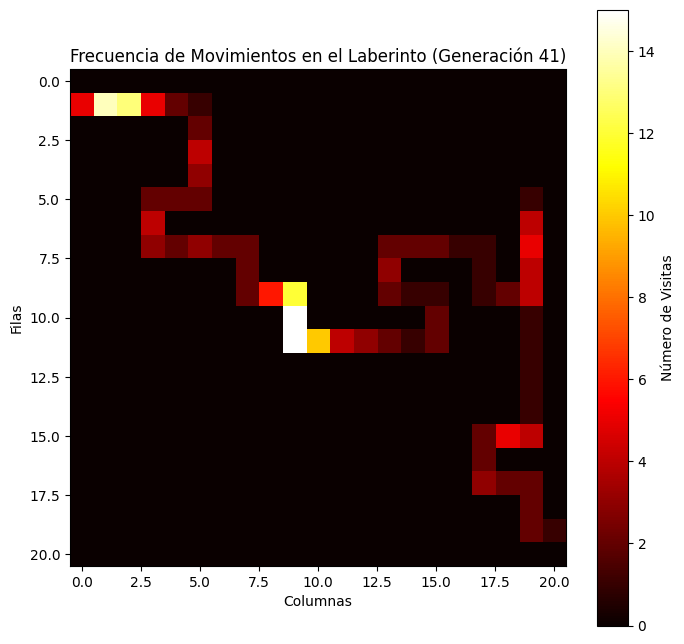

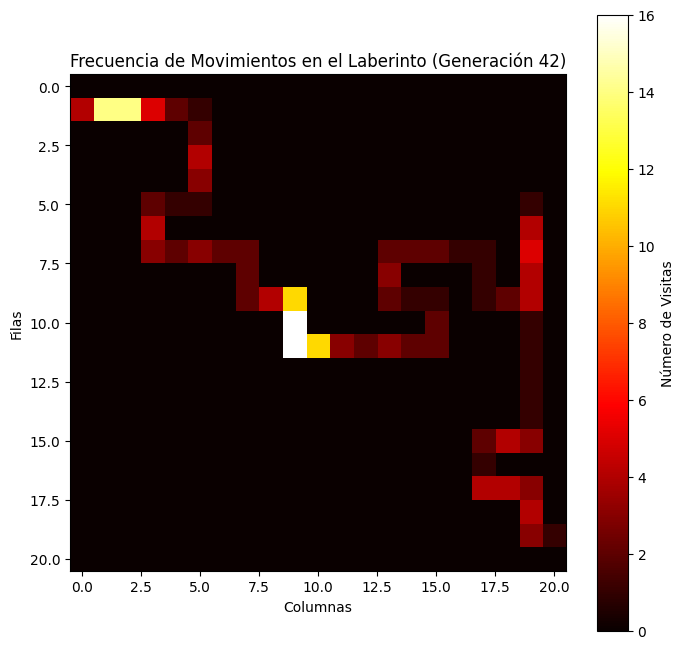

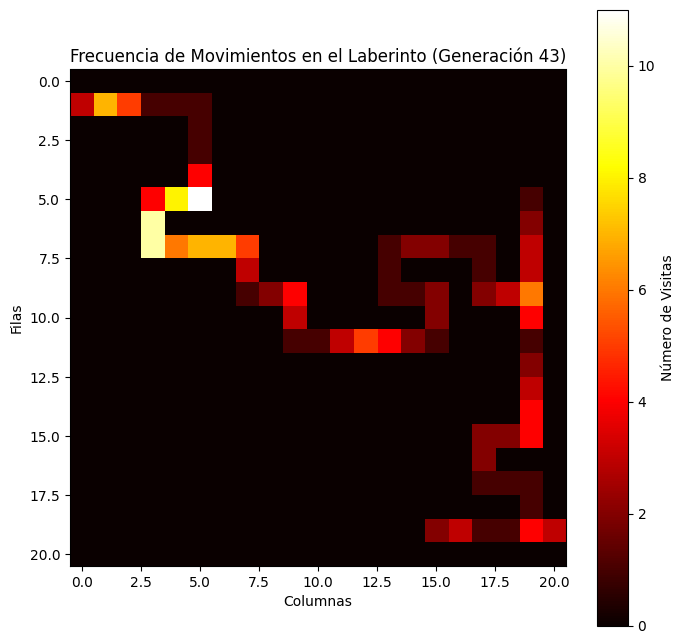

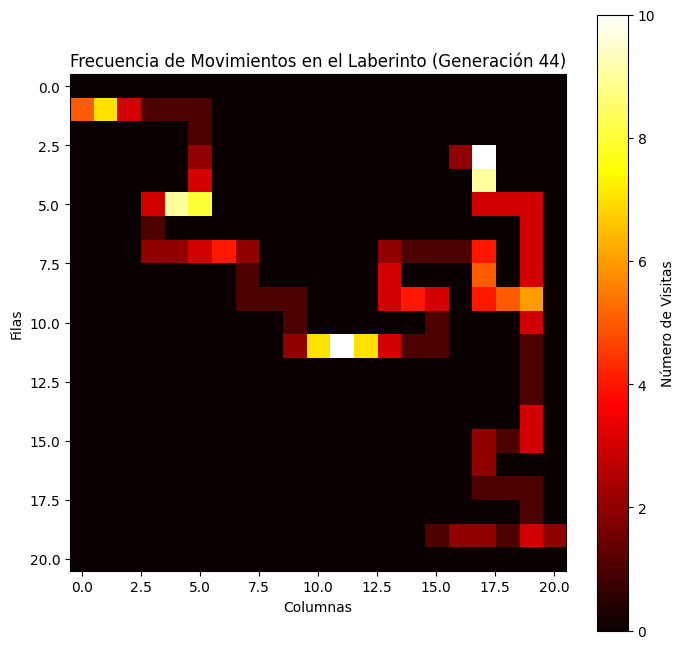

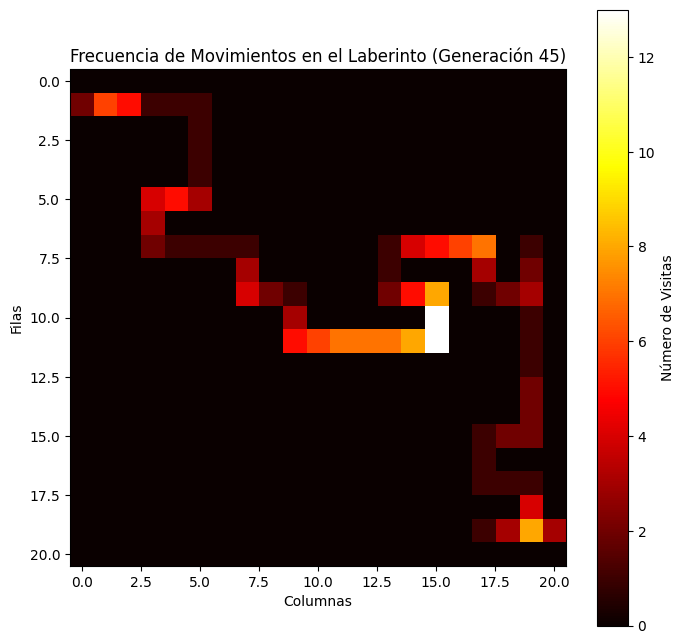

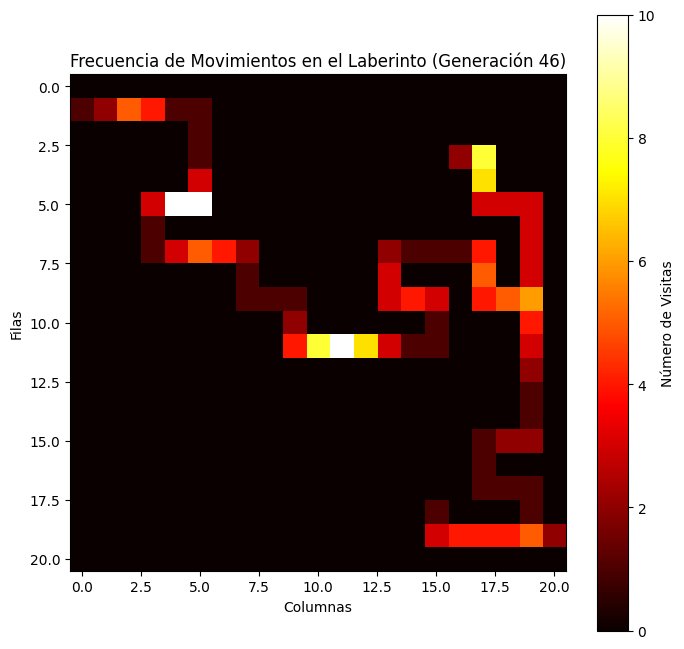

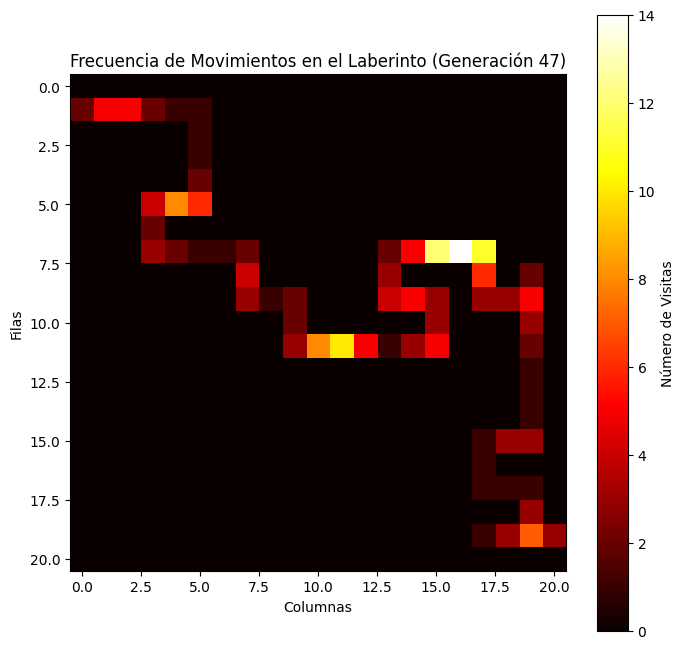

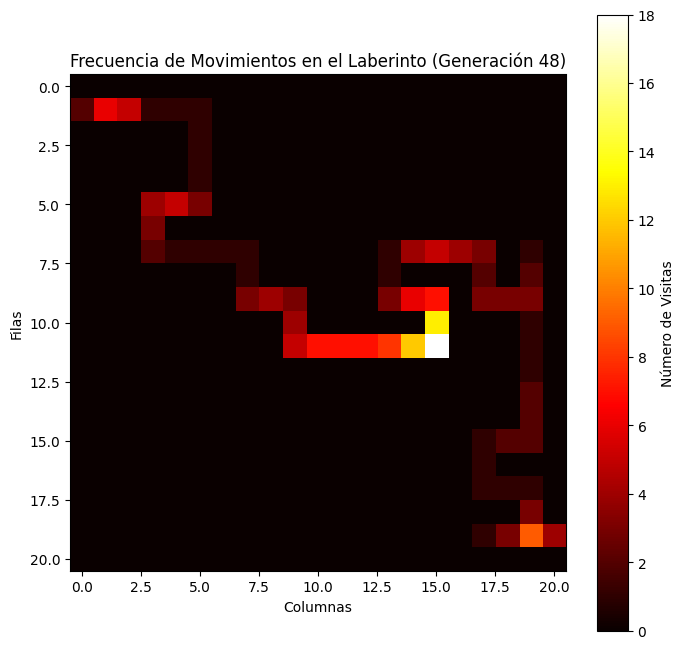

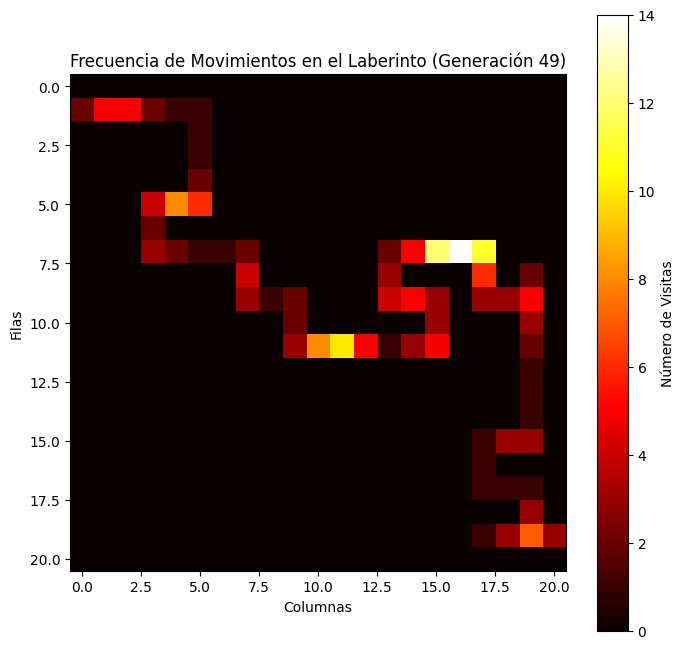

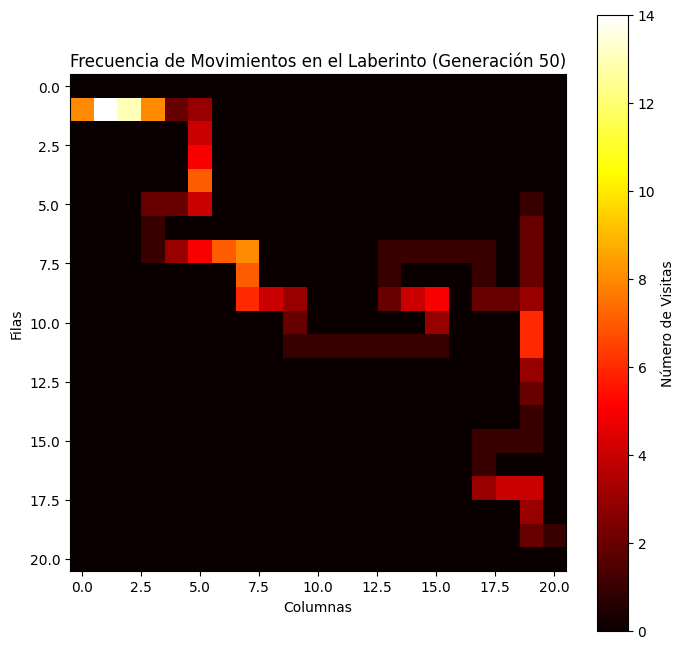

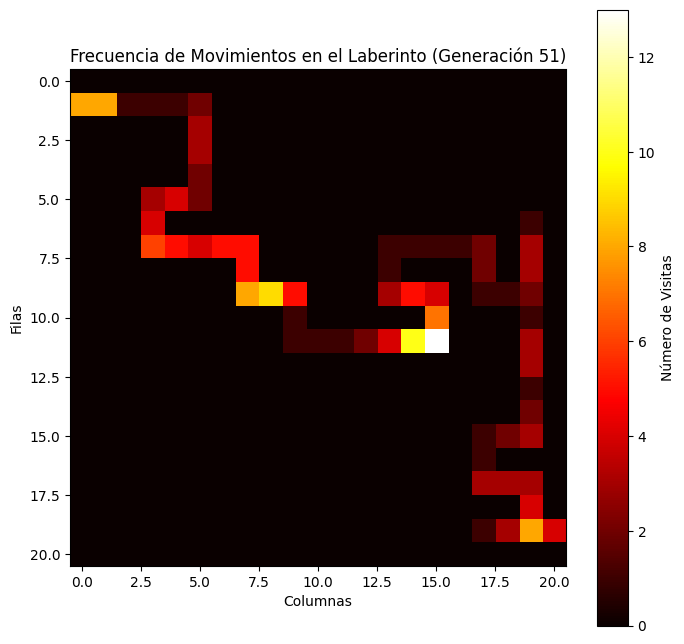

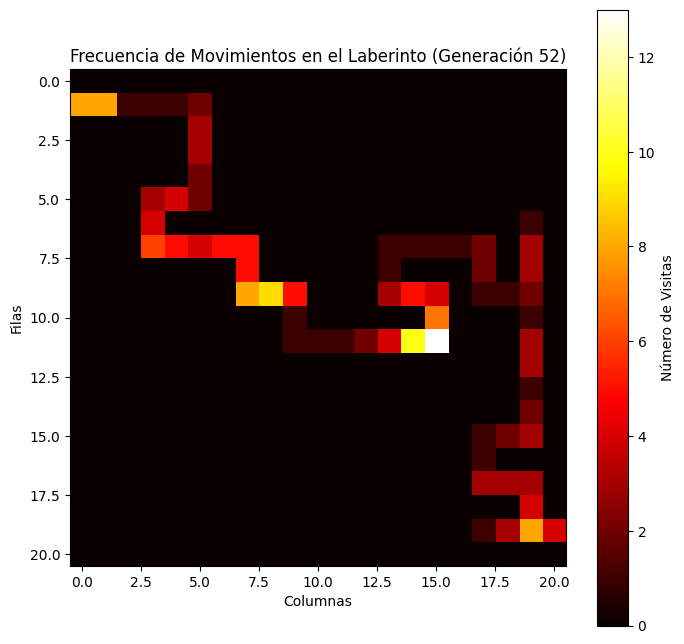

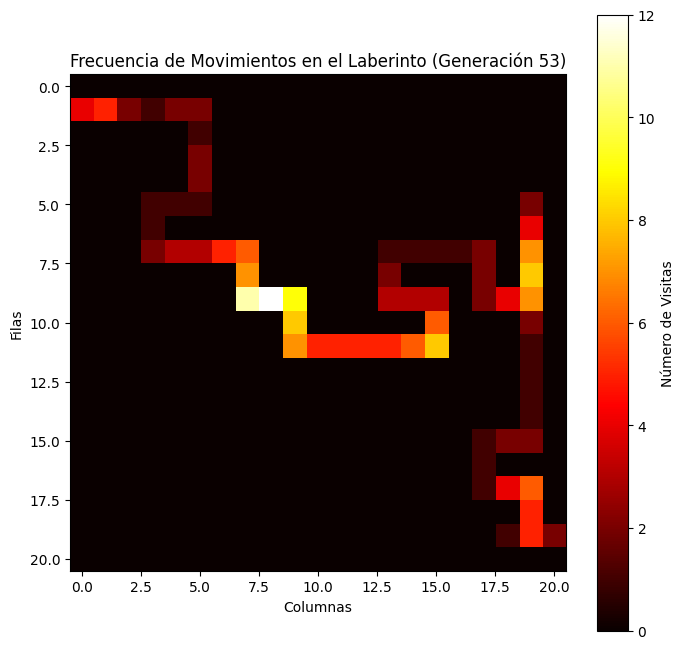

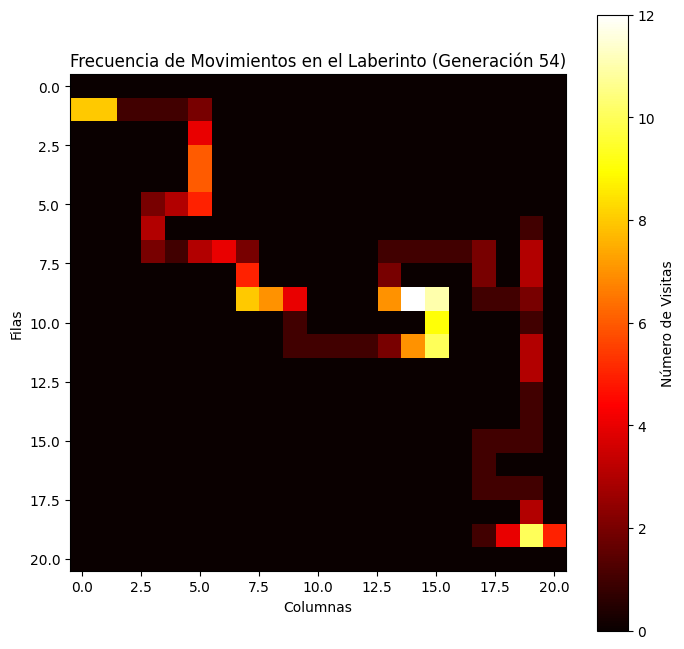

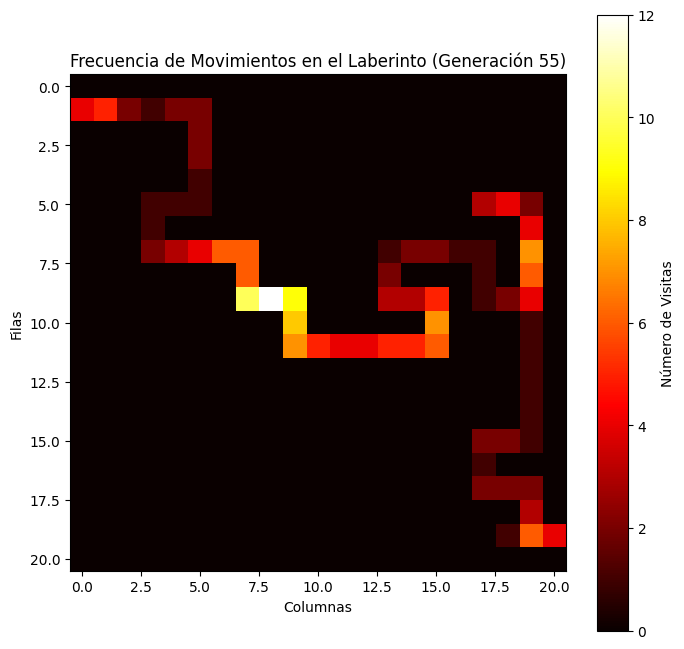

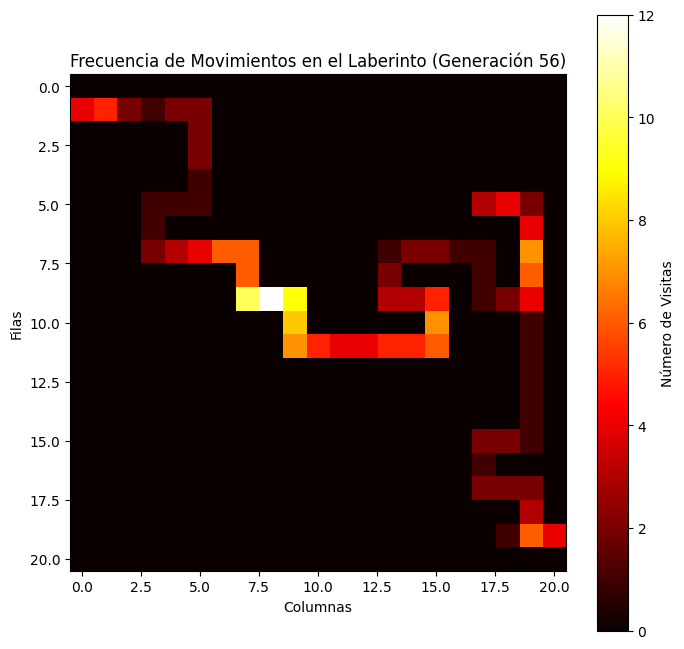

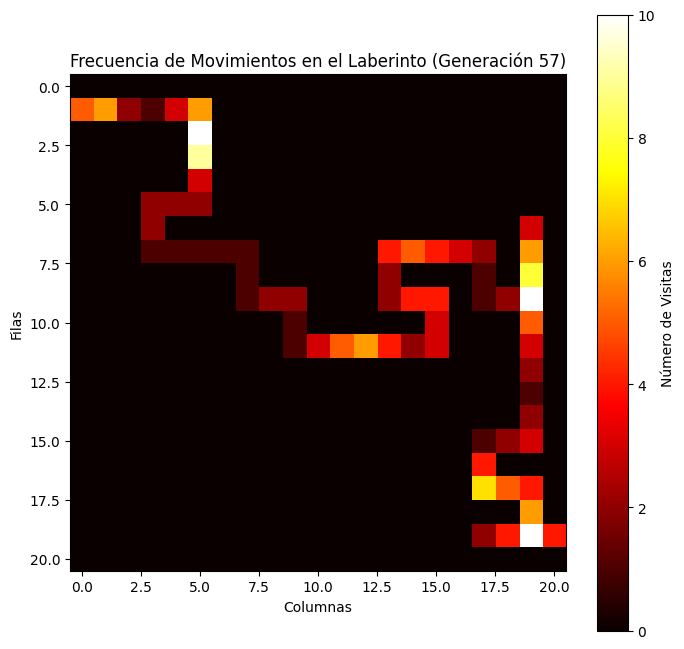

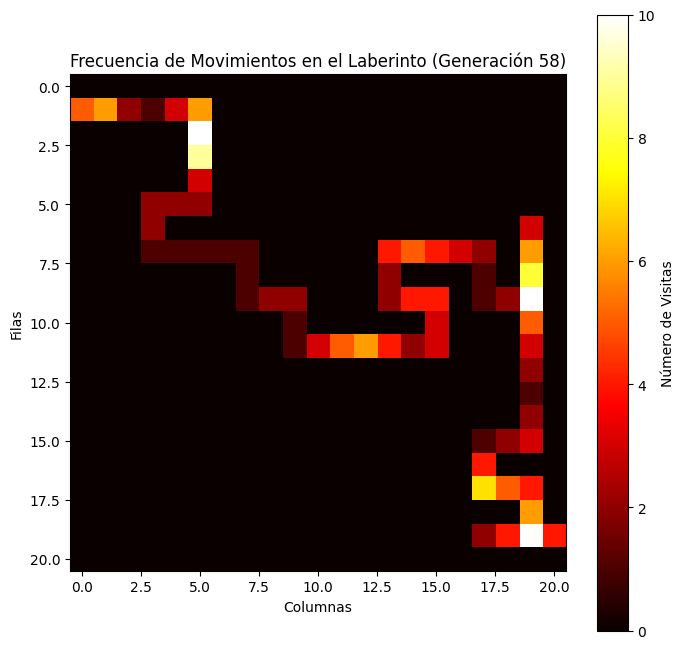

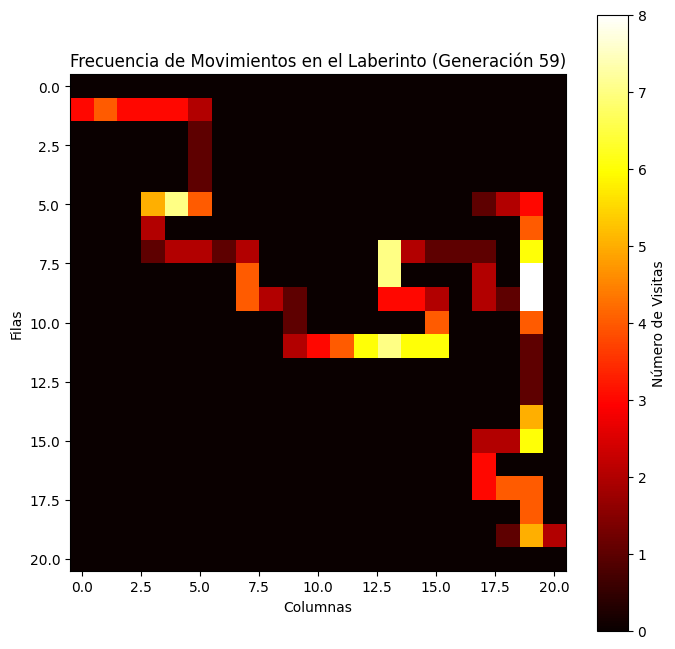

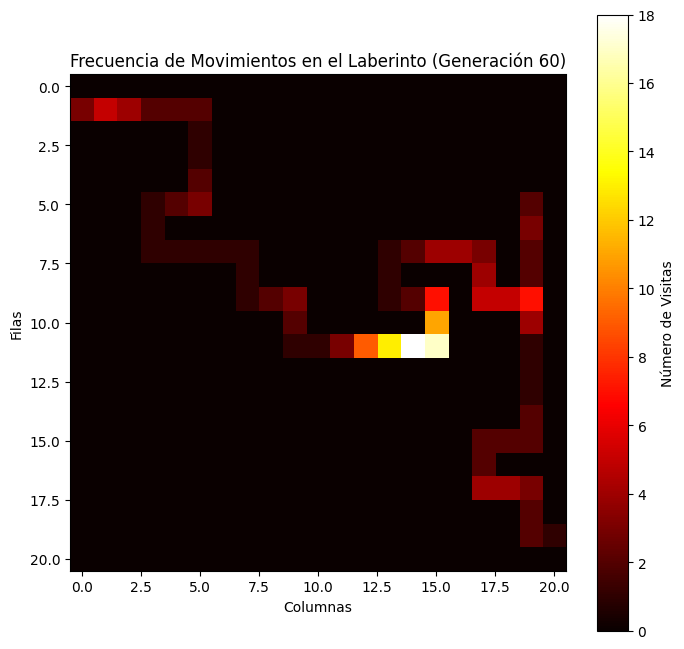

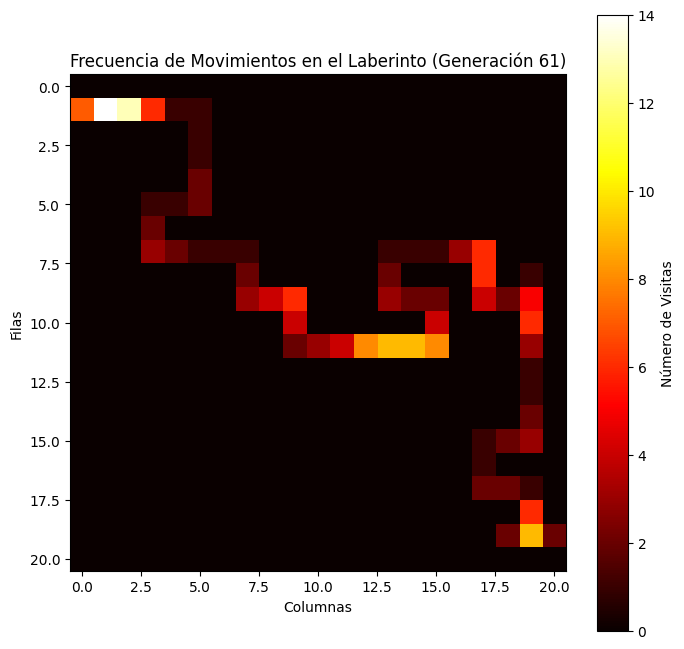

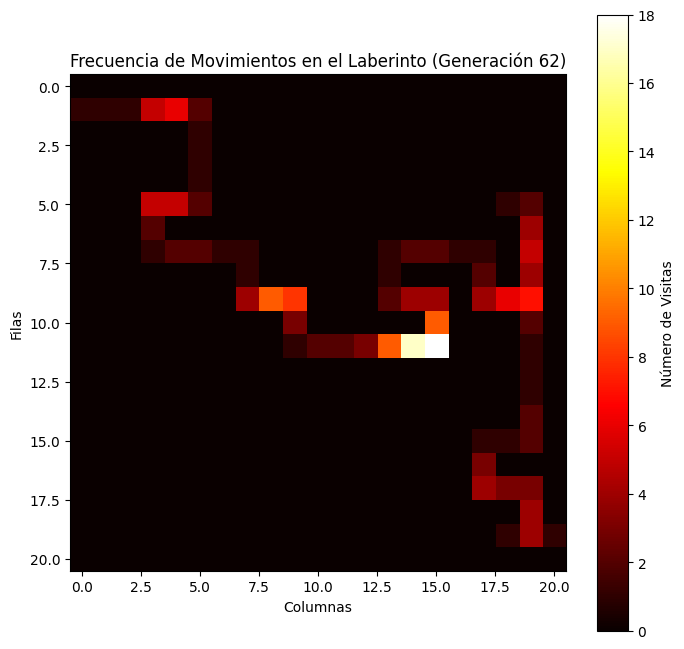

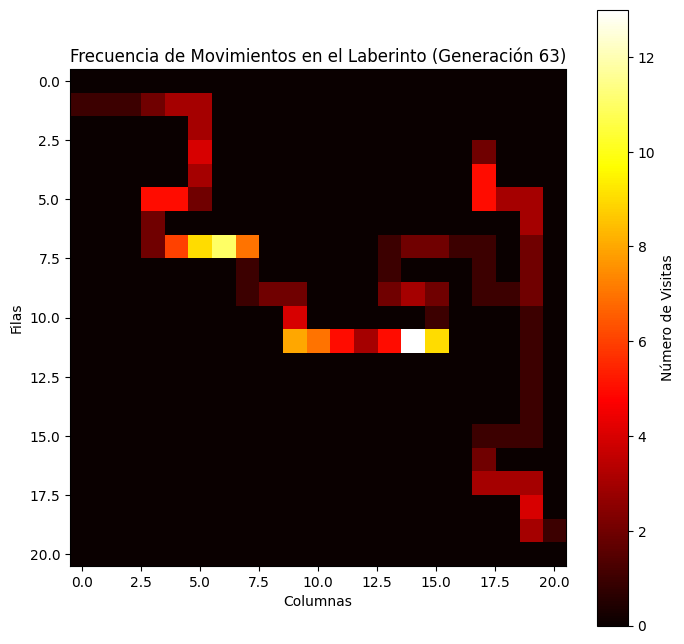

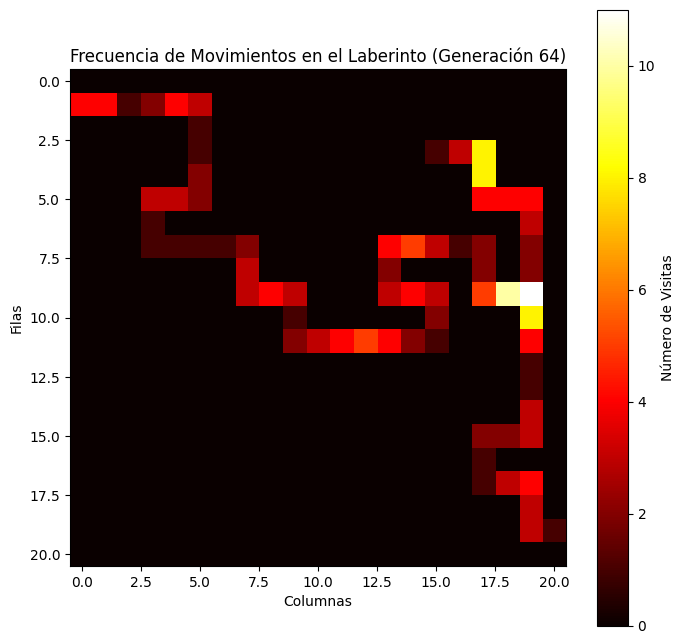

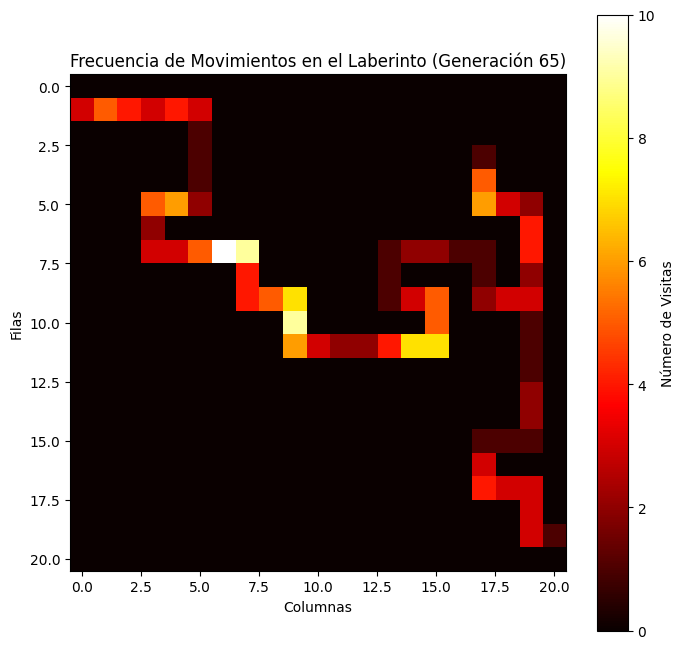

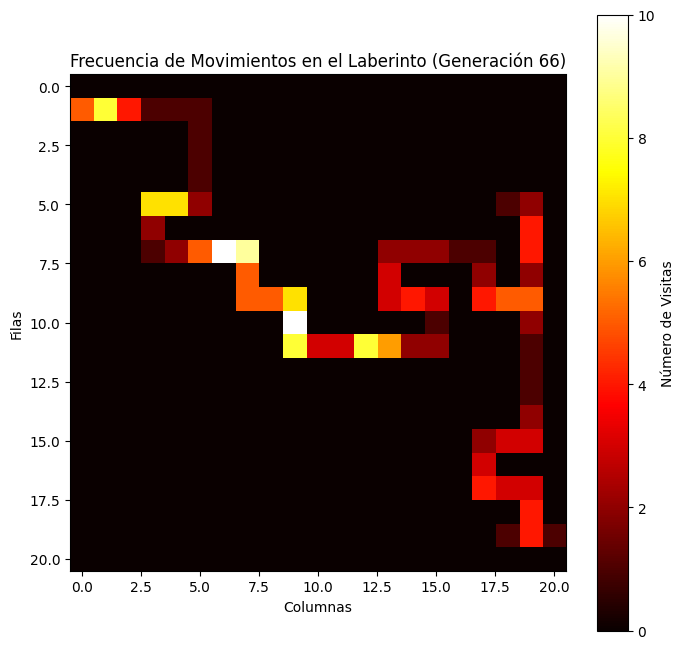

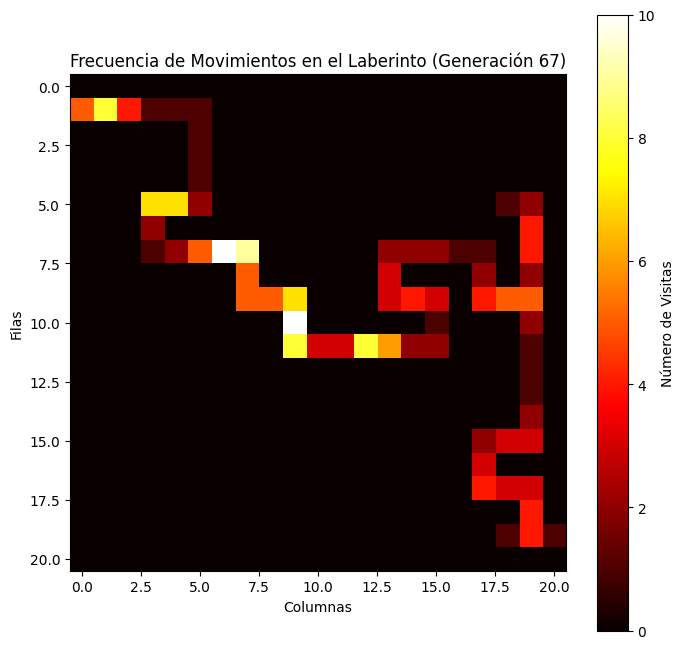

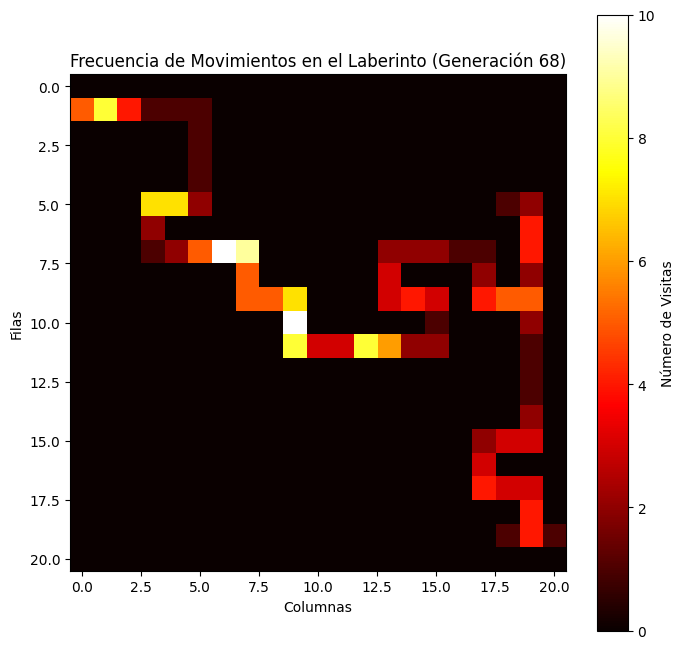

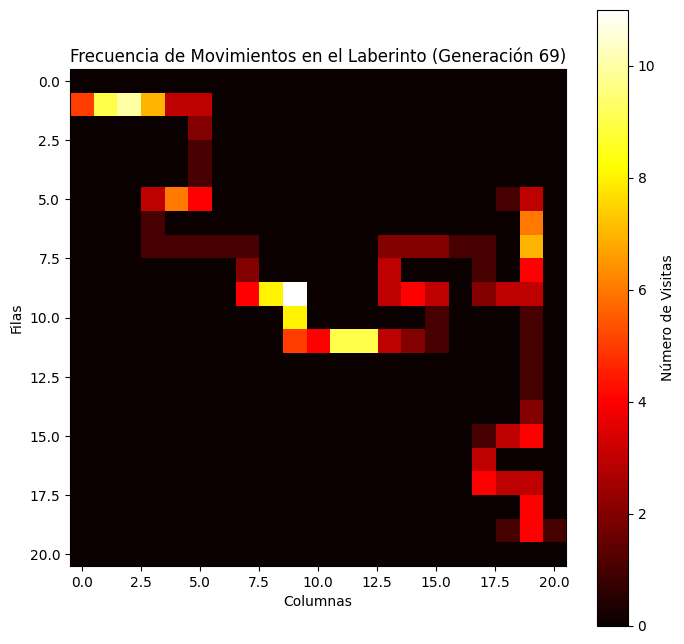

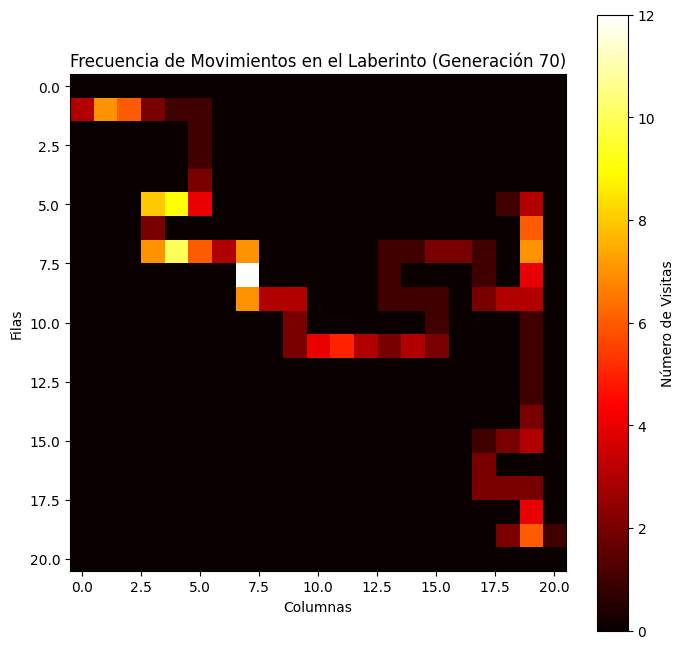

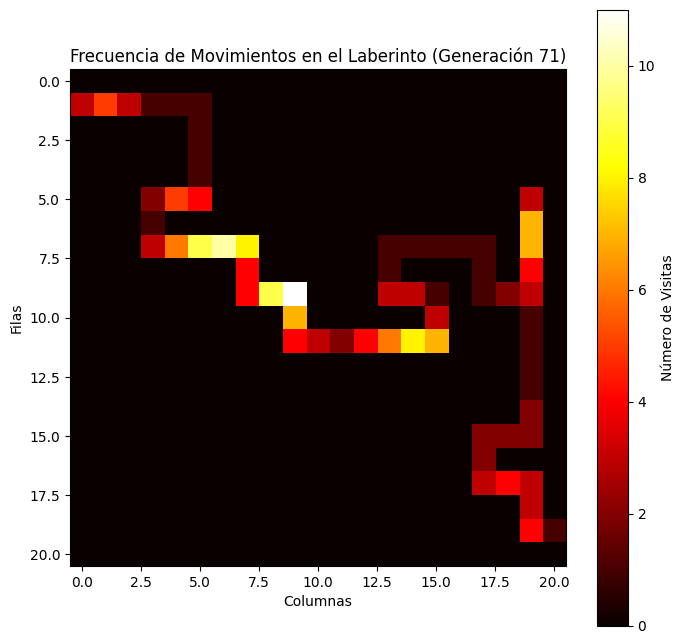

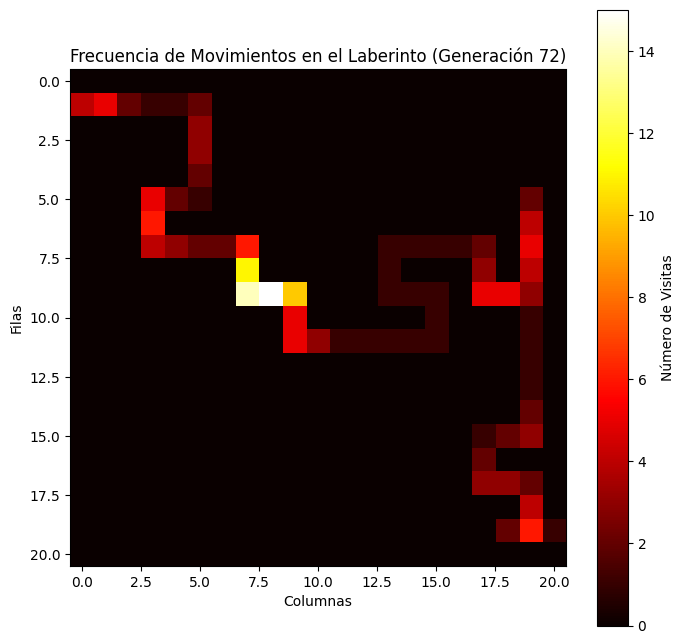

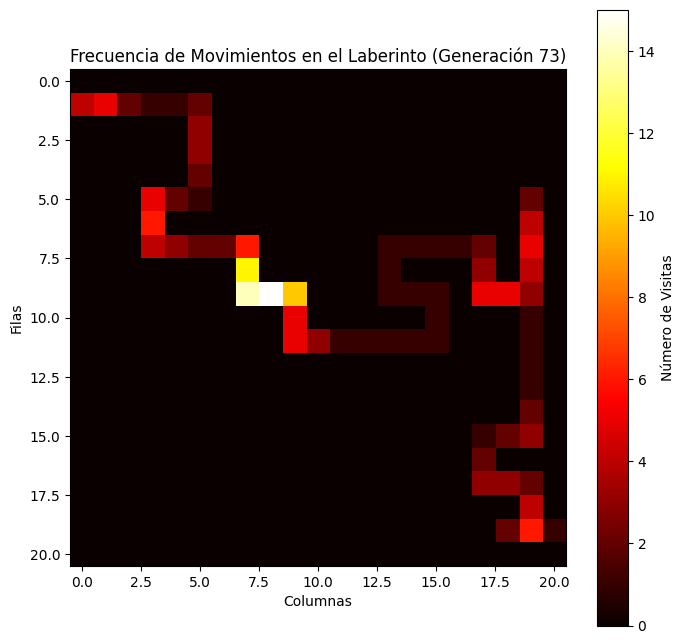

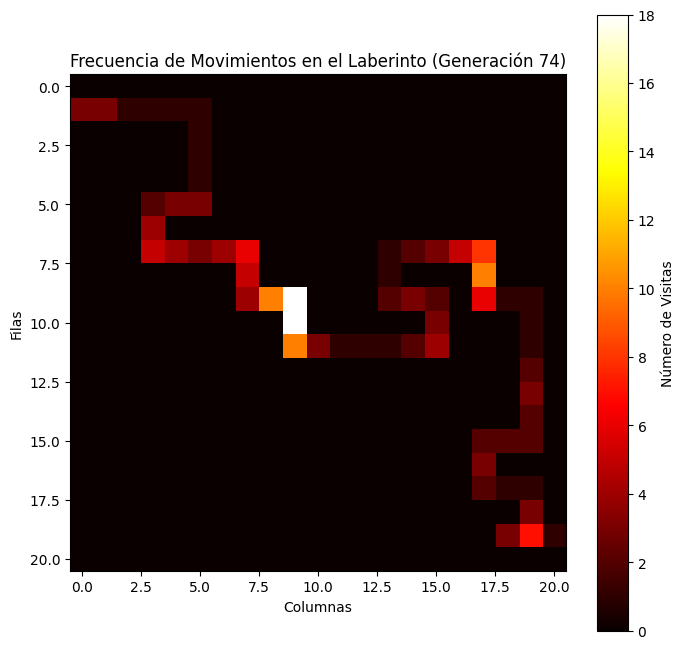

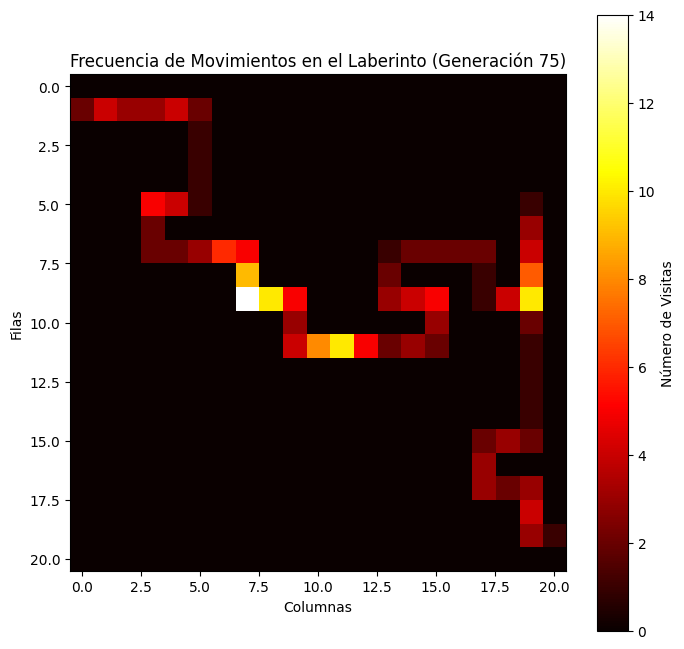

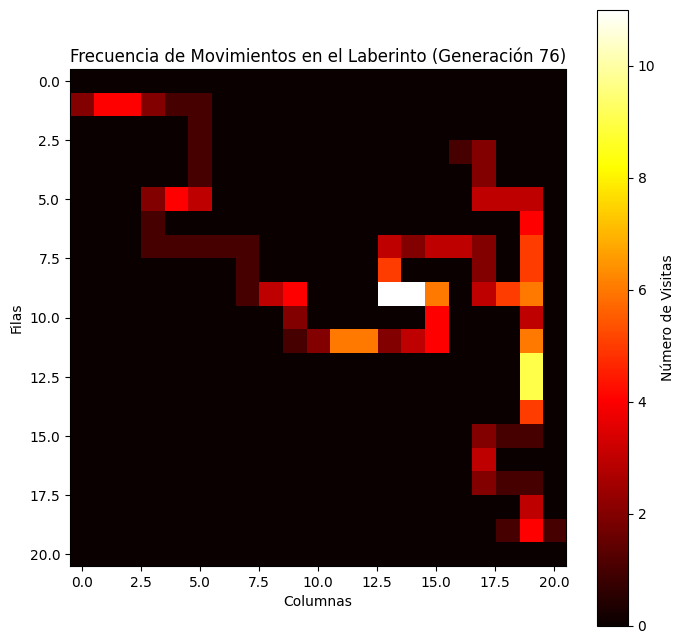

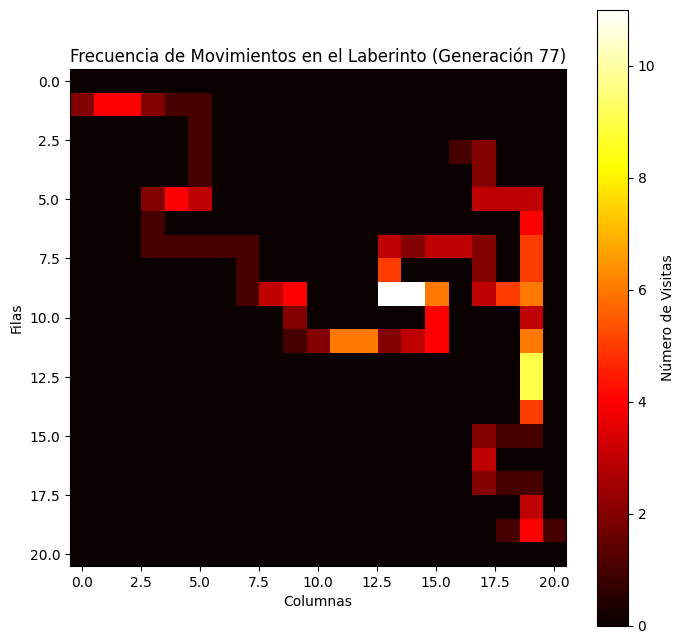

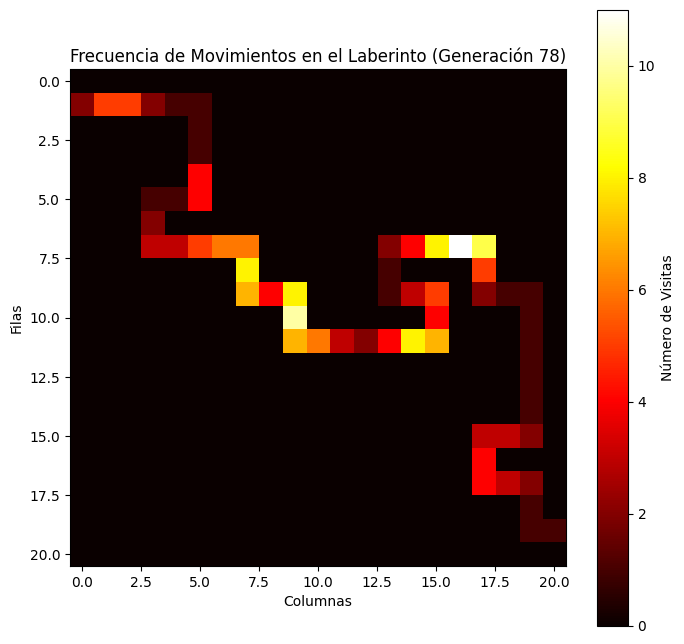

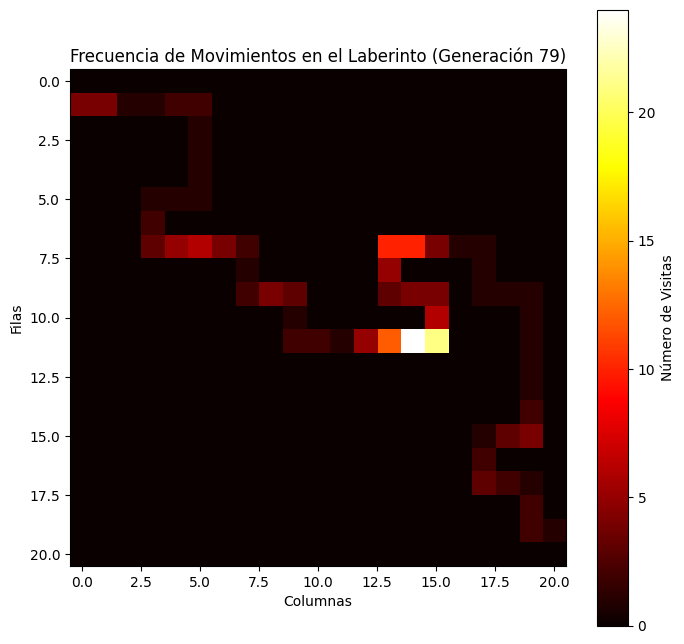

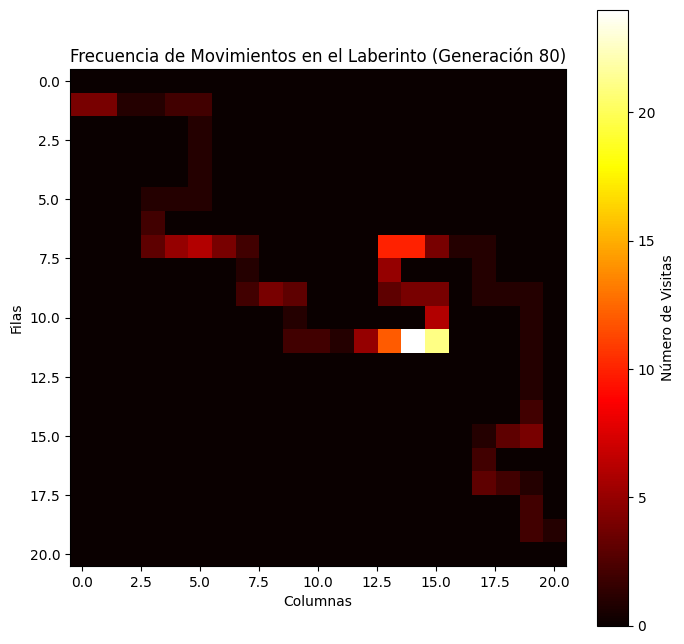

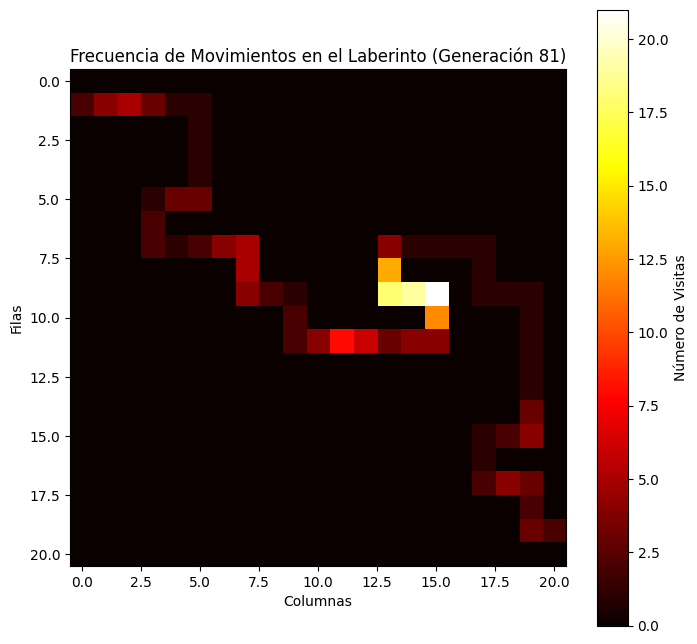

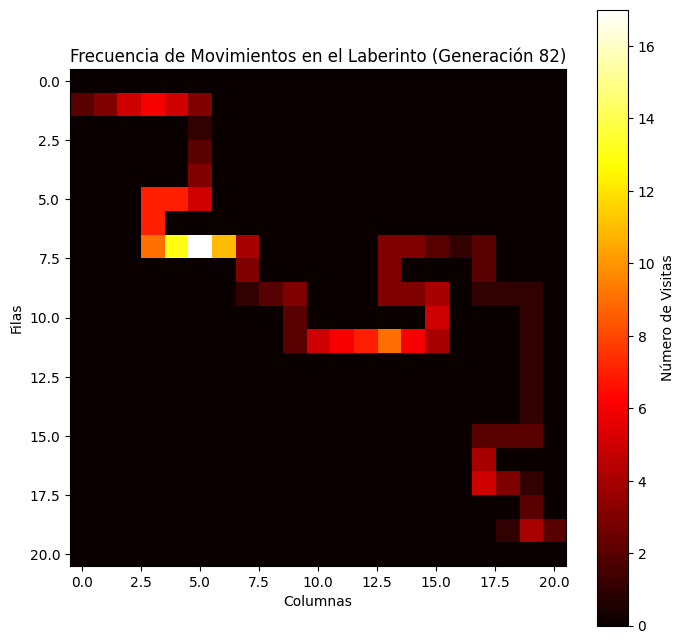

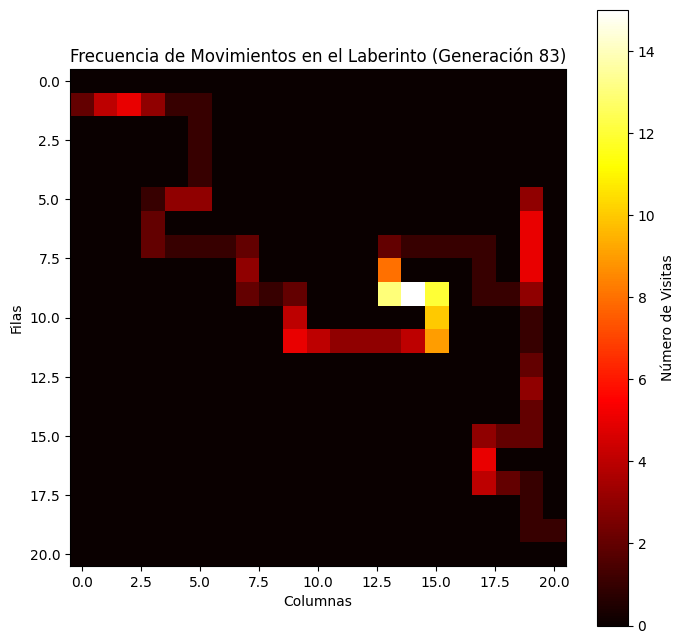

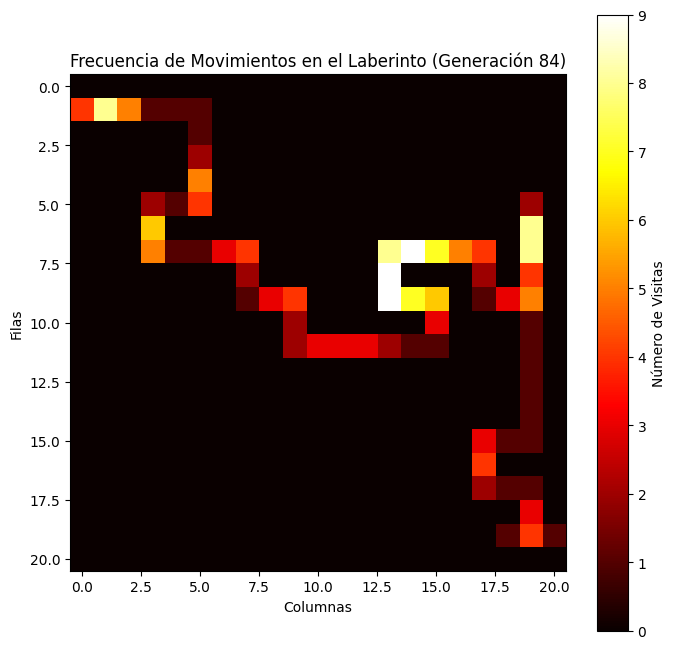

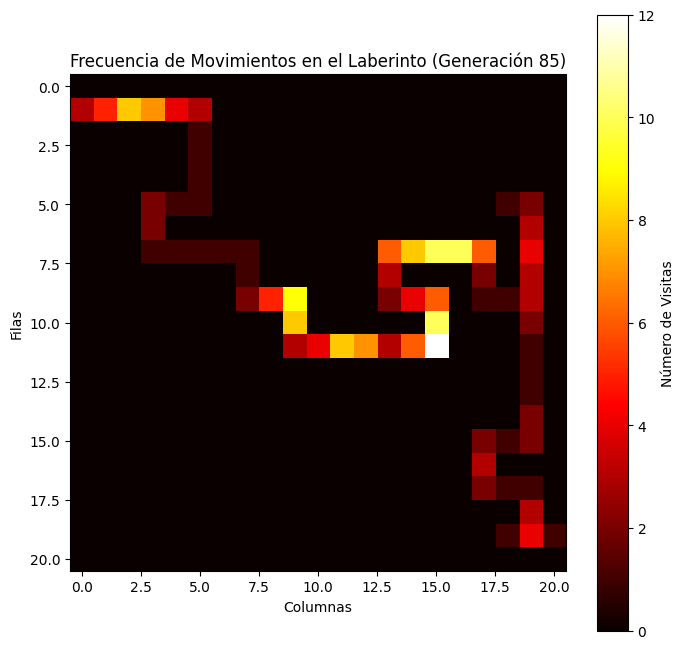

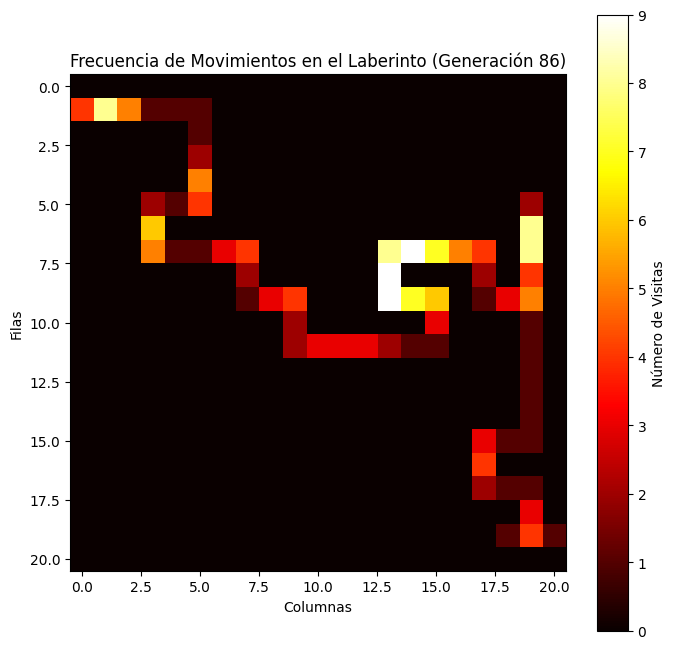

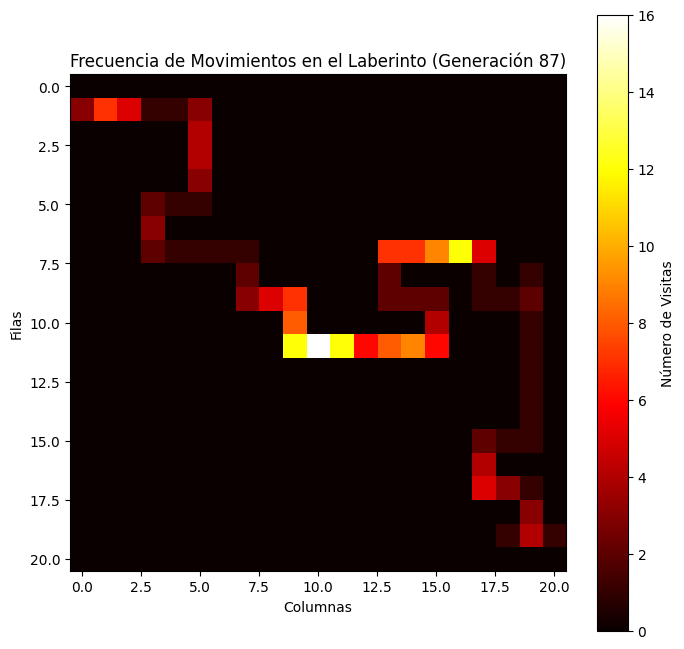

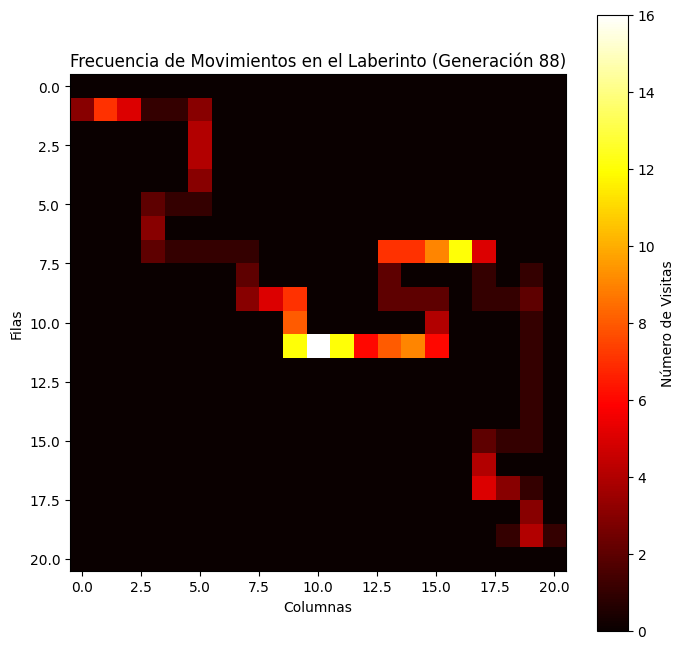

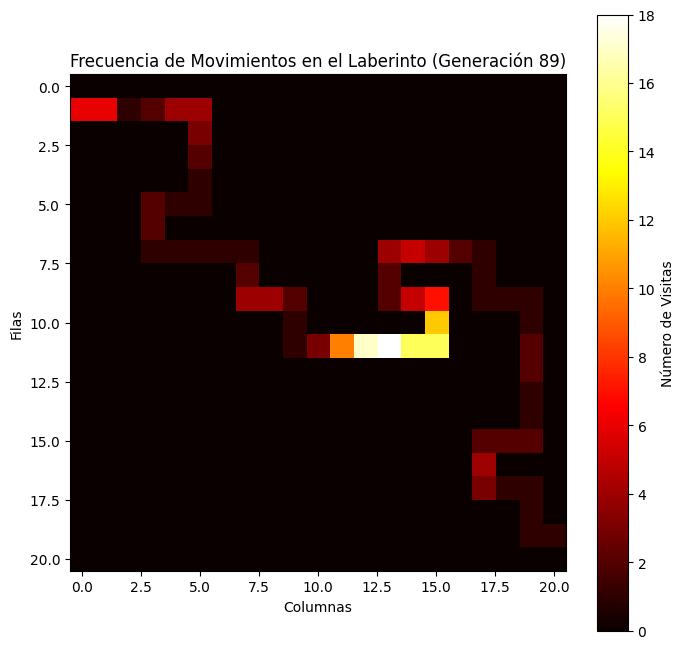

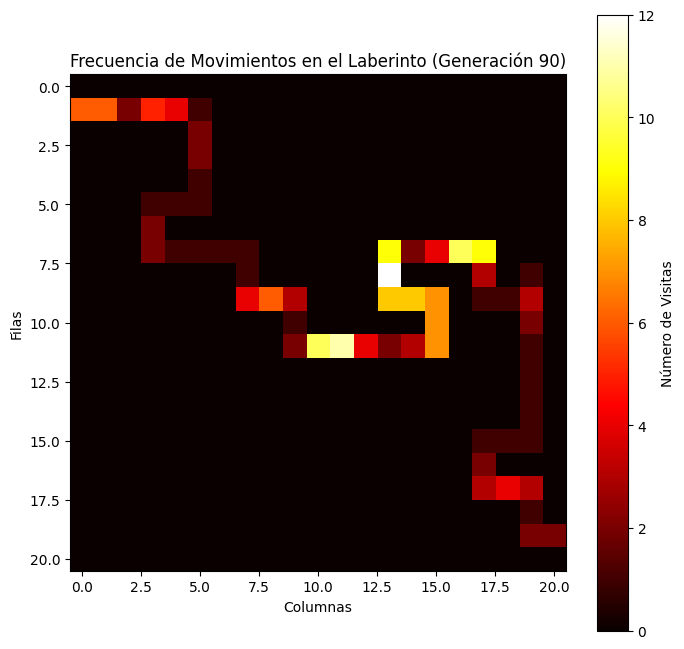

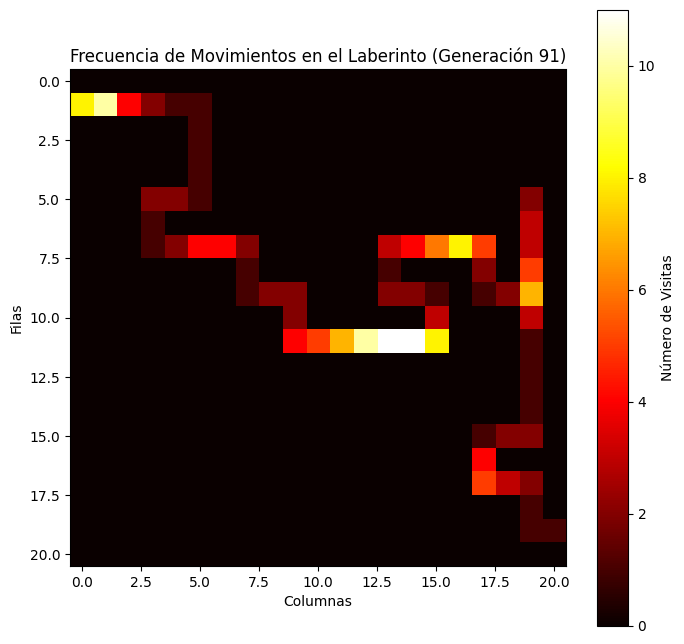

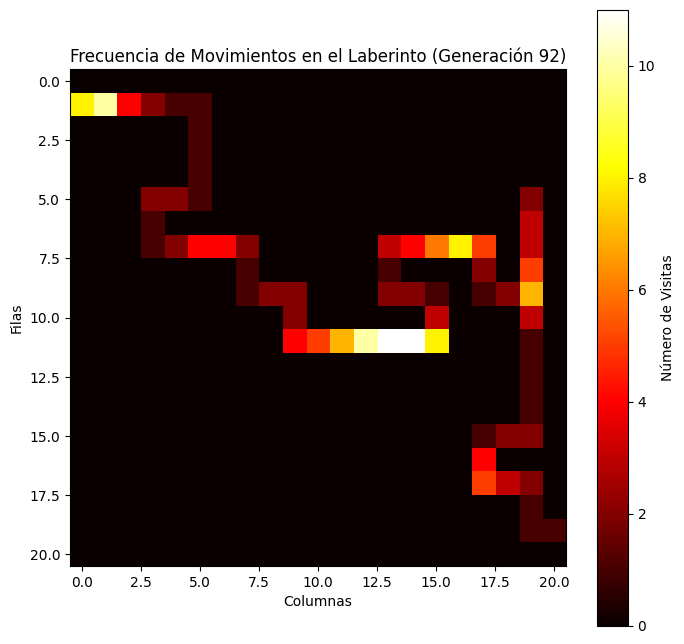

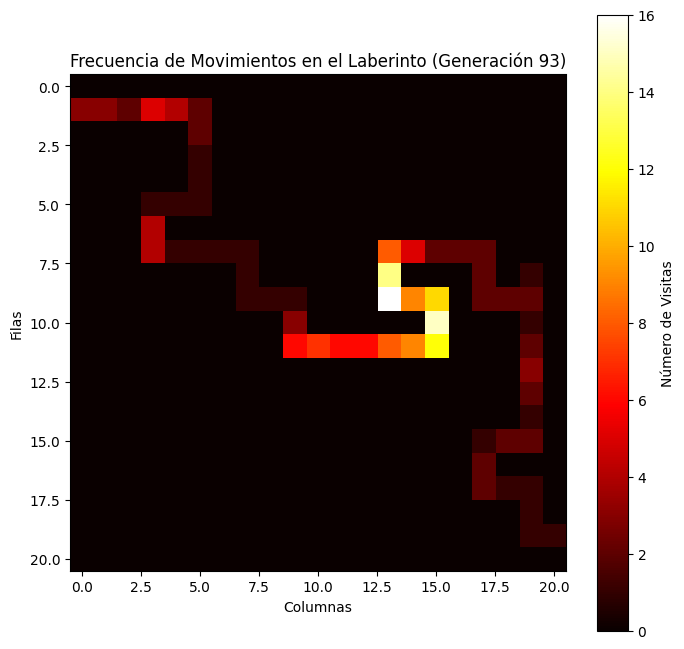

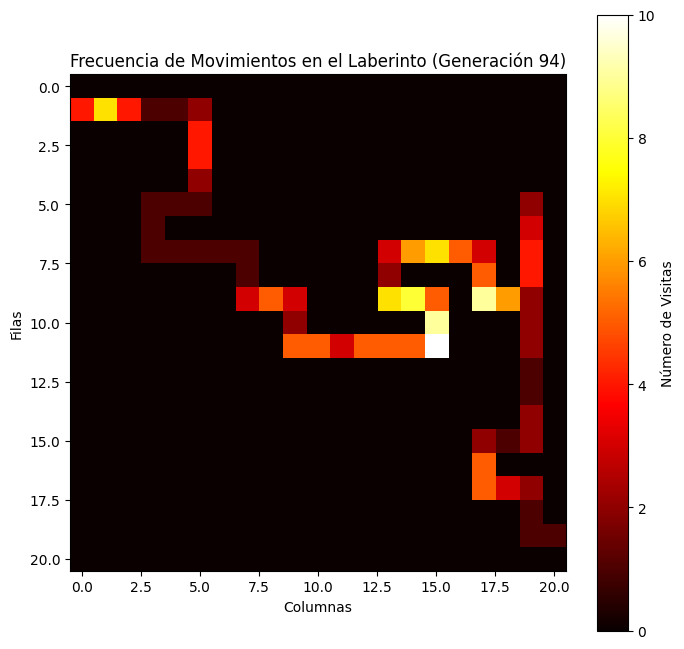

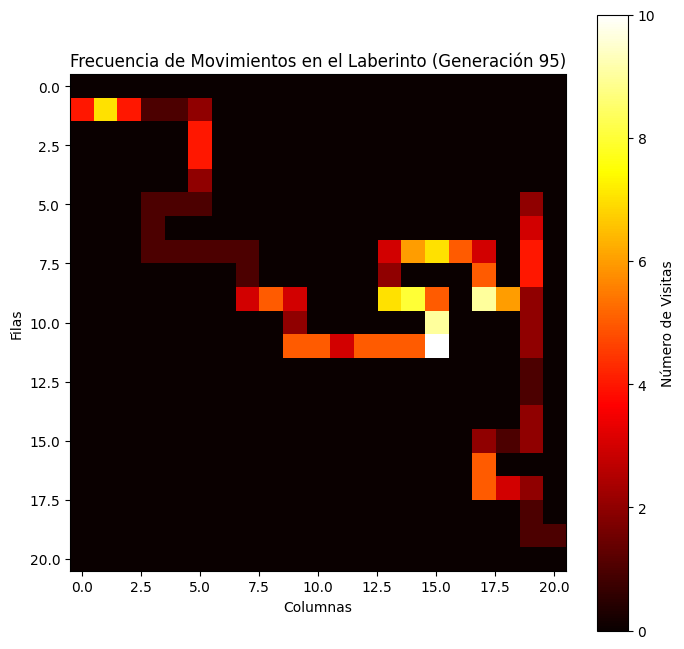

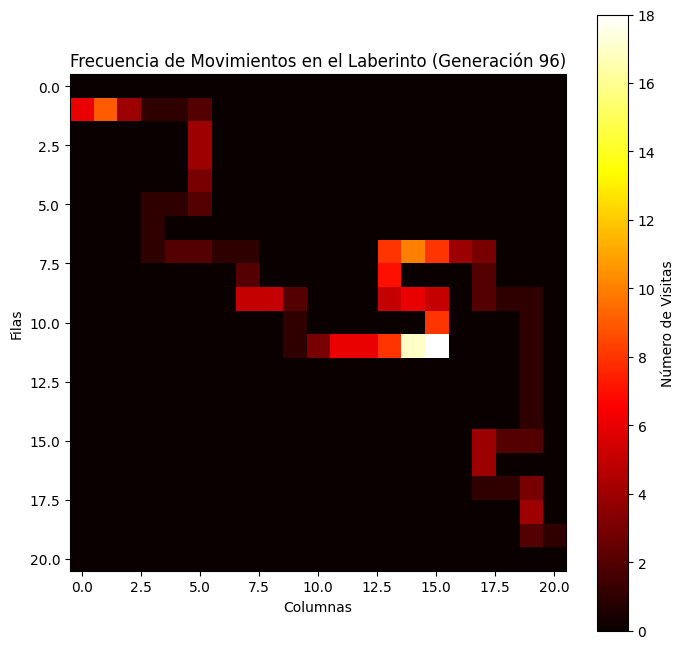

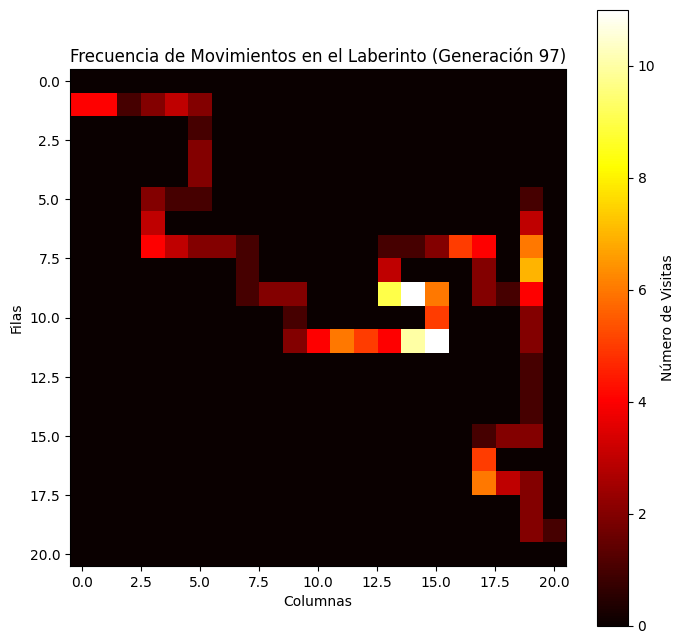

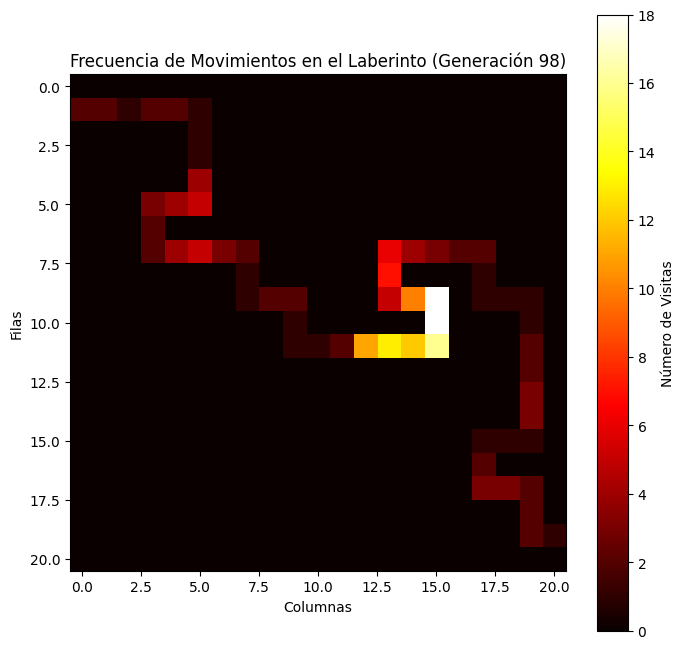

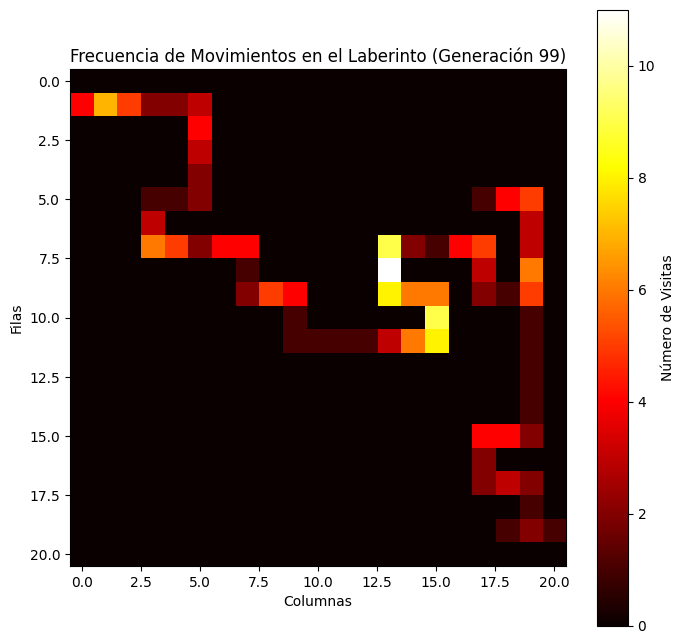

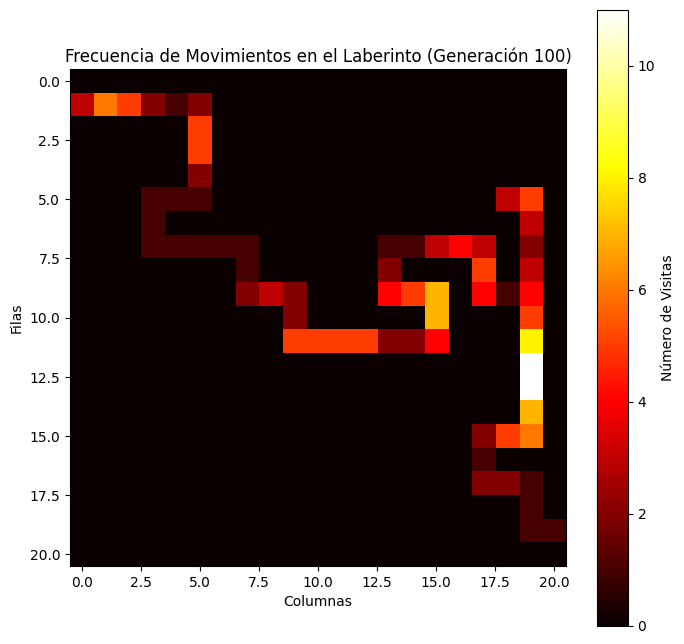

In [18]:
"""
    Resuelve el laberinto utilizando algoritmos genéticos y muestra el mapa de calor asociado al mejor individuo encontrado
"""
solver = GeneticMazeSolver()
population = solver.generate_population(50, 4*dim*dim)
start = (1, 0)
end = (dim * 2 - 1, dim * 2)
solution, fitness = solver.evolve(population, maze, start, end)


# Genoma Alternativo

En el archivo `solucionP3.ipynb` se encuentra una implementación alternativa al problema, basada en un enfoque diferente de genoma. Este enfoque propone una representación que "condensa" las decisiones, aprovechando patrones comunes en las soluciones. Por ejemplo, si en una solución se da un paso en una dirección, es probable que los siguientes pasos también sigan esa misma dirección. Por ello, se define un genoma en el que cada gen tiene la forma (D, C), donde:

- **D**: Representa la dirección (0: Derecha, 1: Izquierda, 2: Arriba, 3: Abajo).  
- **C**: Indica la cantidad de pasos consecutivos en esa dirección.  

Este enfoque alternativo demostró mejoras en el rendimiento en comparación con el genoma clásico, en algunos casos llegando a la solución óptima en menos de 5 generaciones.

También se evaluó otra implementación que consistía en identificar celdas con al menos dos celdas adyacentes libres de obstáculos y utilizarlas como nodos clave en el genoma. En este caso, cada gen representaría una de las posibles rutas a seguir desde esas celdas estratégicas. Sin embargo, descartamos esta idea porque requería un preprocesamiento del laberinto, lo cual iba en contra del propósito principal del ejercicio, que es abordar el problema de manera más directa y dinámica.
